# Assignment 1: Ridge and Lasso Regression (Diabetes Dataset) 

## ML course 2025

### Author: Mahdi Bakhtiari

[GitHub Repository](https://github.com/mahdi-20/diabetes-ml-analysis)


In this exercise, you will use the **Diabetes dataset** (built into scikit-learn) to explore how **Ridge** and **Lasso regression** handle correlated predictors and the effects of regularization. You will compare them to a standard **Linear Regression** model, visualize their coefficients, and interpret how regularization influences **model complexity** and **performance**.

You will also examine the role of **interaction features**, exploring how they can add flexibility to the model and help reduce bias.

We will conduct two sets of experiments:
1. Using only the original features, and
2. Using the original features plus interaction terms.

### Learning Objectives
By the end of this exercise, you will be able to:

- Apply **Ridge** and **Lasso regression** to control model complexity and prevent overfitting.  
- Use **cross-validation** to select the optimal level of regularization (`alpha`).  
- Interpret how regularization affects **coefficient magnitude**, **sparsity**, and **model interpretability**.  
- Evaluate how adding **interaction features** changes model bias, variance, and predictive performance.


### 📘 Step 1: Load & Understand the Diabetes Dataset

A crucial point to understand when working with the diabetes dataset from `sklearn.datasets` is that it is **not raw data**. The feature data (`X`) has already been pre-processed according to a specific normalization scheme.
This is noted by the original author on the data's source webpage ([source](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html)):

**> Note that the 10 x variables have been standardized to have mean 0 and squared length = 1 (sum(x^2)=1).**

To make this clear for anyone using this notebook, we will load both the **raw data** from the source URL and compare it to the **pre-processed data** that comes with `scikit-learn`. This allows for a direct comparison and highlights what "pre-processing" has already been done.

---

##### 👉 The Normalization Equation Used by the Dataset Authors:

The specific transformation applied to each of the 10 feature columns (e.g., `AGE`, `BMI`, etc.) is as follows:

$$
x_{\text{norm}_{ij}} = \frac{x_{ij} - \bar{x}_j}{\sqrt{\sum_{k=1}^{n} (x_{kj} - \bar{x}_j)^2}}
$$

Where:
- $x_{ij}$ is the original value of feature $j$ for sample $i$.
- $\bar{x}_j$ is the mean of all original values for feature $j$.
- $n$ is the total number of samples.
- The summation in the denominator is over all samples $k$ for that feature $j$.

This process ensures two properties for each resulting feature column:
1.  **Mean of 0**: The data is centered.
2.  **Sum of Squares of 1**: The vector for each feature has a unit L2-norm.

---
##### 👉 Data Scaling Equation Used in `StandardScaler`

The scaling transformation that is used in `StandardScaler` can be expressed mathematically as:

$$
X_{\text{scaled}} = \frac{X_{\text{train}} - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

Where:
- $X_{\text{train}}$ is the original feature value from the training data.
- $\mu_{\text{train}}$ is the mean of the feature values computed from the training data.
- $\sigma_{\text{train}}$ is the standard deviation of the feature values computed from the training data.

For the test data, the scaling transformation is applied as:

$$
X_{\text{test, scaled}} = \frac{X_{\text{test}} - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

Where:
- $X_{\text{test}}$ is the original feature value from the test data.
- $\mu_{\text{train}}$ and $\sigma_{\text{train}}$ are the mean and standard deviation computed from the training data, respectively.

**Note:** It is crucial to use the mean ($\mu_{\text{train}}$) and standard deviation ($\sigma_{\text{train}}$) from the training data for scaling the test data. This ensures that the test data is transformed in the same way as the training data, maintaining consistency and preventing data leakage.

---
To understand how the Diabetes dataset was preprocessed, we compare the raw data we downloaded with the version included in `sklearn.datasets.load_diabetes`. This comparison shows that scikit-learn’s dataset has already been normalized according to the transformation described by equation above.



Let’s start by loading the dataset from `sklearn.datasets` and from the URL and reviewing them.

In [176]:
import pandas as pd

# The URL of the raw data
url = 'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt'

# Use pandas to read the tab-separated file directly from the URL
# sep='\t' tells pandas that the columns are separated by tabs
try:
    df_raw = pd.read_csv(url, sep='\t')

    # Now the data is in a pandas DataFrame called 'df'
    print("Raw data loaded successfully!")
    display(df_raw.head())
    print("")
    print("The data shape is: ", df_raw.shape)

    # --- To save this data to a local file (e.g., a CSV) ---
    # This is useful if you want a local copy for offline use
    output_filename = 'diabetes_data.csv'
    df_raw.to_csv(output_filename, index=False) # index=False prevents pandas from writing the DataFrame index as a column
    print(f"\nData saved locally to '{output_filename}'")
    

except Exception as e:
    print(f"An error occurred: {e}")



Raw data loaded successfully!


AGE  SEX   BMI     BP   S1     S2    S3   S4      S5  S6    Y
0   59    2  32.1  101.0  157   93.2  38.0  4.0  4.8598  87  151
1   48    1  21.6   87.0  183  103.2  70.0  3.0  3.8918  69   75
2   72    2  30.5   93.0  156   93.6  41.0  4.0  4.6728  85  141
3   24    1  25.3   84.0  198  131.4  40.0  5.0  4.8903  89  206
4   50    1  23.0  101.0  192  125.4  52.0  4.0  4.2905  80  135


The data shape is:  (442, 11)

Data saved locally to 'diabetes_data.csv'


#### And loading the data from `sklearn.datasets` which are normalized.

In [202]:

from sklearn.datasets import load_diabetes
import pandas as pd

# Load dataset
data = load_diabetes(as_frame=True)
X = data.data
y = data.target

print(f"Shape of the features dataframe : {X.shape}")
print("")
print("First 5 rows from the sklearn dataset [Already normalized]:")
X.head()


Shape of the features dataframe : (442, 10)

First 5 rows from the sklearn dataset [Already normalized]:


age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641

Let's get more information of the dataset.

In [163]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

**Feature descriptions**: Below is the feature descriptions for the diabetes dataset. Note that the data is already scaled.

In [164]:
feature_info = {
    "age": "Age (years)",
    "sex": "Sex (1 = male, 2 = female)",
    "bmi": "Body mass index (kg/m²)",
    "bp": "Average blood pressure",
    "s1": "TC – T-Cell count (cholesterol-related)",
    "s2": "LDL – Low-Density Lipoproteins (bad cholesterol)",
    "s3": "HDL – High-Density Lipoproteins (good cholesterol)",
    "s4": "TCH – Total Cholesterol",
    "s5": "LTG – Log of serum triglycerides level",
    "s6": "GLU – Blood sugar level (glucose)"
}

import pandas as pd
pd.DataFrame(feature_info.items(), columns=["Feature", "Description"])

Feature                                        Description
0     age                                        Age (years)
1     sex                         Sex (1 = male, 2 = female)
2     bmi                            Body mass index (kg/m²)
3      bp                             Average blood pressure
4      s1            TC – T-Cell count (cholesterol-related)
5      s2   LDL – Low-Density Lipoproteins (bad cholesterol)
6      s3  HDL – High-Density Lipoproteins (good choleste...
7      s4                            TCH – Total Cholesterol
8      s5             LTG – Log of serum triglycerides level
9      s6                  GLU – Blood sugar level (glucose)

Let's performe the follwoing calculations:
- Normalizing the **raw data** using the equation shown above. It should give the same results stored in the `sklearn.datasets.diabetes`
- Applying `StandardScaler` on the **raw data** from the `sklearn.preprocessing`
- Applying `StandardScaler` on the **normalized data**

In [166]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


# Exact feature list (order fixed)
FEATURES = ["AGE","SEX","BMI","BP","S1","S2","S3","S4","S5","S6"]
X = df_raw[FEATURES].astype(float)   # force float and fixed order

# -------- A) Sklearn-style z-score (population std, ddof=0) --------
scaler = StandardScaler(with_mean=True, with_std=True)  # default ddof=0
X_std_sklearn = pd.DataFrame(scaler.fit_transform(X), columns=[f"{c}_std" for c in FEATURES])


# -------- B) Diabetes normalization (mean 0, sum of squares = 1) --------
X_diab = pd.DataFrame(index=X.index)
for c in FEATURES:
    centered = X[c] - X[c].mean()
    denom = np.sqrt((centered**2).sum())
    X_diab[f"{c}_diab"] = centered / denom

# -------- C) Raw columns (for side-by-side) --------
X_raw = X.copy()
X_raw.columns = [f"{c}_raw" for c in FEATURES]

# -------- D) Combine in grouped order: raw, std (sklearn), diab (and optional sample-std) --------
cols_grouped = []
for c in FEATURES:
    cols_grouped += [f"{c}_raw", f"{c}_std", f"{c}_diab"]  # add f"{c}_std_sample" if you want to compare
combined = pd.concat([X_raw, X_std_sklearn, X_diab], axis=1)[cols_grouped]

# -------- E) Sanity checks (optional) --------
# 1) Sklearn z-scores should have ~0 mean, ~1 variance (population variance close to 1)
# 2) Diabetes normalization should have ~0 mean and sum of squares == 1 per column
# print(combined.head())
# print("Sklearn means ~0:\n", X_std_sklearn.mean().round(6))
# print("Sklearn var ~1 (np.var ddof=0):\n", np.var(X_std_sklearn.values, axis=0).round(6))
# print("Diabetes means ~0:\n", X_diab.mean().round(6))
# print("Diabetes sumsq = 1:\n", (X_diab**2).sum().round(6))

# If you only want to see the table:
#pd.set_option('display.max_columns', None)
#print(combined.head().round(6))

display("This is the 5 first rows of raw data of diabetes normalization:",X_raw.head().round(6))
X_std_sklearn_normalize = pd.DataFrame(scaler.fit_transform(X_raw), columns=[f"{c}_std" for c in FEATURES])


print("This is the 5 first rows of diabetes after normalization [Same as the tabulated data in sklearn.datasets] :")
display(X_diab.head().round(6))

print("This is the data after applying standardscaler on the diabetes raw data :")
display(X_std_sklearn_normalize.head().round(6))



X_std_sklearn_normalize_scale = pd.DataFrame(scaler.fit_transform(X_diab), columns=[f"{c}_std" for c in FEATURES])
print("This is the data after applying standardscaler on the diabetes normalized data \n[gives same data to the standardized diabetes]:")
display(X_std_sklearn_normalize_scale.head().round(6))



'This is the 5 first rows of raw data of diabetes normalization:'

AGE_raw  SEX_raw  BMI_raw  BP_raw  S1_raw  S2_raw  S3_raw  S4_raw  S5_raw  \
0     59.0      2.0     32.1   101.0   157.0    93.2    38.0     4.0  4.8598   
1     48.0      1.0     21.6    87.0   183.0   103.2    70.0     3.0  3.8918   
2     72.0      2.0     30.5    93.0   156.0    93.6    41.0     4.0  4.6728   
3     24.0      1.0     25.3    84.0   198.0   131.4    40.0     5.0  4.8903   
4     50.0      1.0     23.0   101.0   192.0   125.4    52.0     4.0  4.2905   

   S6_raw  
0    87.0  
1    69.0  
2    85.0  
3    89.0  
4    80.0

This is the 5 first rows of diabetes after normalization [Same as the tabulated data in sklearn.datasets] :


AGE_diab  SEX_diab  BMI_diab   BP_diab   S1_diab   S2_diab   S3_diab  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

    S4_diab   S5_diab   S6_diab  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641

This is the data after applying standardscaler on the diabetes raw data :


AGE_std   SEX_std   BMI_std    BP_std    S1_std    S2_std    S3_std  \
0  0.800500  1.065488  1.297088  0.459841 -0.929746 -0.732065 -0.912451   
1 -0.039567 -0.938537 -1.082180 -0.553505 -0.177624 -0.402886  1.564414   
2  1.793307  1.065488  0.934533 -0.119214 -0.958674 -0.718897 -0.680245   
3 -1.872441 -0.938537 -0.243771 -0.770650  0.256292  0.525397 -0.757647   
4  0.113172 -0.938537 -0.764944  0.459841  0.082726  0.327890  0.171178   

     S4_std    S5_std    S6_std  
0 -0.054499  0.418531 -0.370989  
1 -0.830301 -1.436589 -1.938479  
2 -0.054499  0.060156 -0.545154  
3  0.721302  0.476983 -0.196823  
4 -0.054499 -0.672502 -0.980568

This is the data after applying standardscaler on the diabetes normalized data 
[gives same data to the standardized diabetes]:


AGE_std   SEX_std   BMI_std    BP_std    S1_std    S2_std    S3_std  \
0  0.800500  1.065488  1.297088  0.459841 -0.929746 -0.732065 -0.912451   
1 -0.039567 -0.938537 -1.082180 -0.553505 -0.177624 -0.402886  1.564414   
2  1.793307  1.065488  0.934533 -0.119214 -0.958674 -0.718897 -0.680245   
3 -1.872441 -0.938537 -0.243771 -0.770650  0.256292  0.525397 -0.757647   
4  0.113172 -0.938537 -0.764944  0.459841  0.082726  0.327890  0.171178   

     S4_std    S5_std    S6_std  
0 -0.054499  0.418531 -0.370989  
1 -0.830301 -1.436589 -1.938479  
2 -0.054499  0.060156 -0.545154  
3  0.721302  0.476983 -0.196823  
4 -0.054499 -0.672502 -0.980568

#### Now let's print the statistical parameters for each set of data.

In [ ]:
# Statistical parameters for raw data
means_raw = X_raw.mean()
stds_raw = X_raw.std(ddof=0)  # population std

# Statistical parameters for diabetes-normalized data
means_diab = X_diab.mean()
stds_diab = X_diab.std(ddof=0)  # population std    

#statistical parameters for normalized and standardized data
means_std = X_std_sklearn_normalize_scale.mean()
stds_std = X_std_sklearn_normalize_scale.std(ddof=0)  # population std

print("Means of raw data:\n", means_raw.round(6))
print("Standard deviations of raw data:\n", stds_raw.round(6))
print("\nMeans of diabetes-normalized data:\n", means_diab.round(6))
print("Standard deviations of diabetes-normalized data:\n", stds_diab.round(6))
print("\nMeans of normalized and standardized data:\n", means_std.round(6))
print("Standard deviations of normalized and standardized data:\n", stds_std.round(6))



# Assume 'x_diab' is your existing DataFrame.
# For a runnable example, let's create a sample DataFrame.
# In your actual code, you would already have 'x_diab' loaded.
# Sample DataFrame creation (comment this out if you already have 'x_diab')
# import pandas as pd

# Define the output filename
output_filename = 'x_diab_data.csv'

# Save the DataFrame to a CSV file without the index
X_diab.to_csv(output_filename, index=False)

#print(f"DataFrame successfully saved to '{output_filename}'")


Means of raw data:
 AGE_raw     48.518100
SEX_raw      1.468326
BMI_raw     26.375792
BP_raw      94.647014
S1_raw     189.140271
S2_raw     115.439140
S3_raw      49.788462
S4_raw       4.070249
S5_raw       4.641411
S6_raw      91.260181
dtype: float64
Standard deviations of raw data:
 AGE_raw    13.094190
SEX_raw     0.498996
BMI_raw     4.413121
BP_raw     13.815628
S1_raw     34.568880
S2_raw     30.378658
S3_raw     12.919562
S4_raw      1.288989
S5_raw      0.521799
S6_raw     11.483322
dtype: float64

Means of diabetes-normalized data:
 AGE_diab   -0.0
SEX_diab    0.0
BMI_diab    0.0
BP_diab     0.0
S1_diab    -0.0
S2_diab    -0.0
S3_diab    -0.0
S4_diab    -0.0
S5_diab     0.0
S6_diab     0.0
dtype: float64
Standard deviations of diabetes-normalized data:
 AGE_diab    0.047565
SEX_diab    0.047565
BMI_diab    0.047565
BP_diab     0.047565
S1_diab     0.047565
S2_diab     0.047565
S3_diab     0.047565
S4_diab     0.047565
S5_diab     0.047565
S6_diab     0.047565
dtype: float64

Index(['AGE_std', 'SEX_std', 'BMI_std', 'BP_std', 'S1_std', 'S2_std', 'S3_std',
       'S4_std', 'S5_std', 'S6_std'],
      dtype='object')

### <img src="Visual_icon.png" alt="drawing" width="50"/> Data Visualization





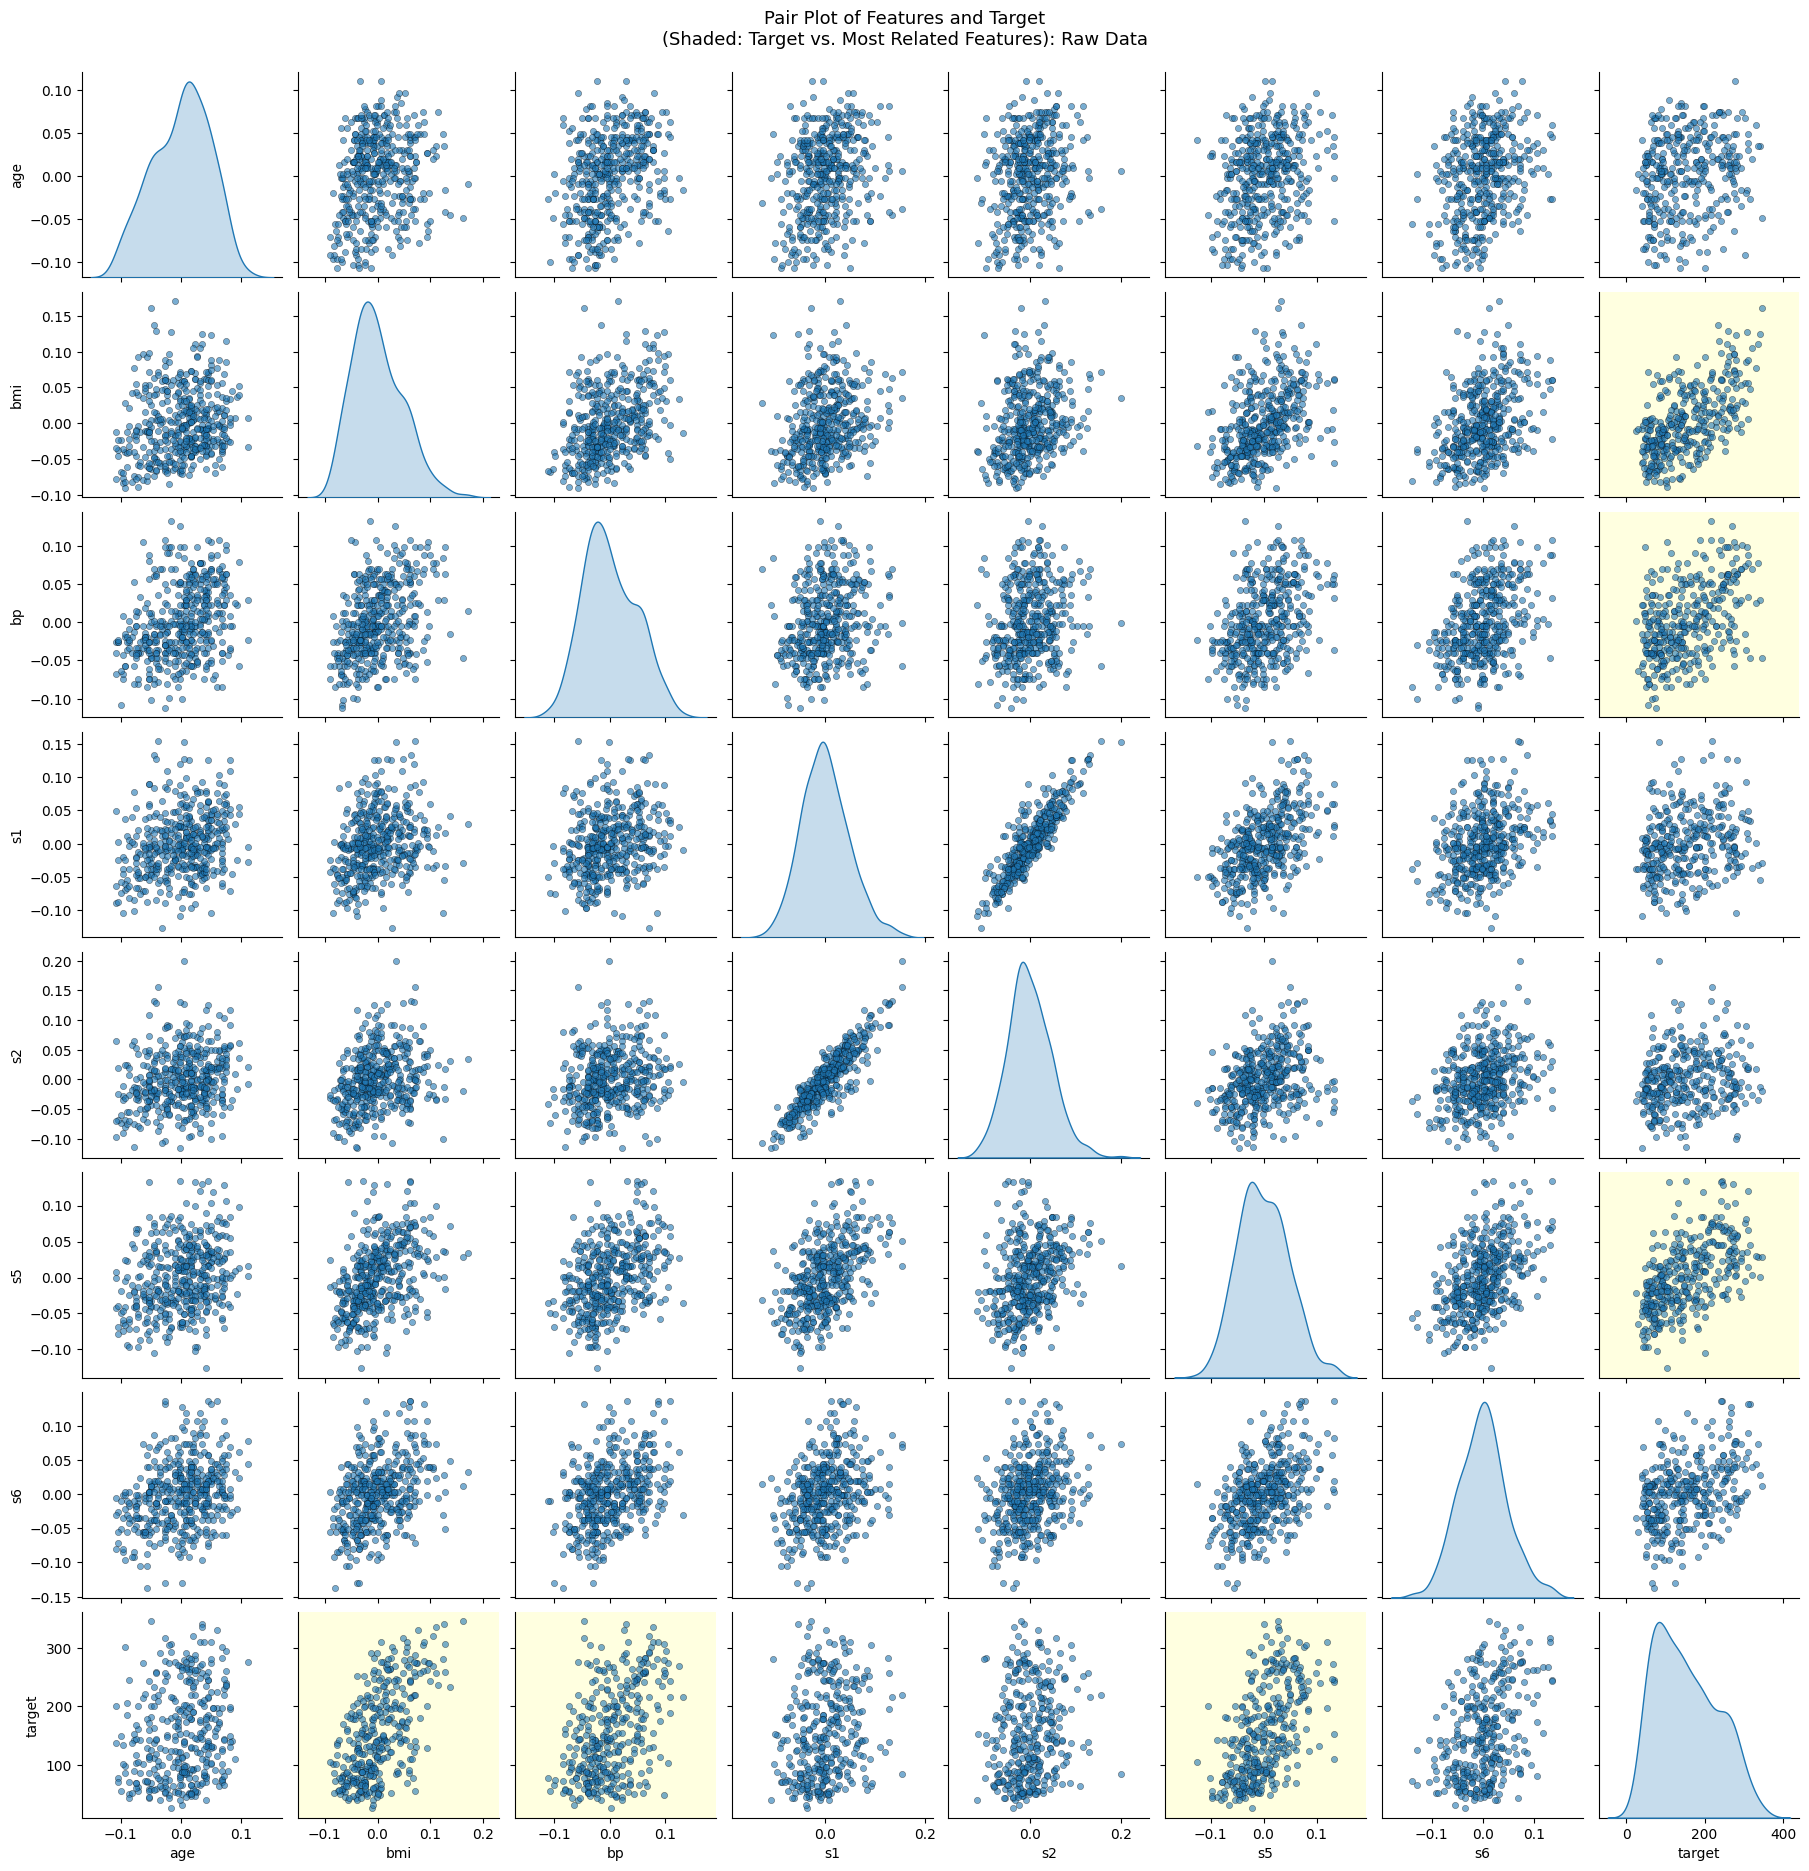

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Combine X and y into one dataframe
df_raw = X.copy()
df_raw['target'] = y

# Normalize column names to lowercase for consistency
df_raw.columns = [c.lower() for c in df_raw.columns]

# Define the most correlated features (based on your correlation matrix)
highlight_features = ['age', 'bmi', 'bp', 's1', 's2', 's5', 's6']

correlated_features = ['bmi', 'bp', 's5']


# Select variables for the pair plot (only ones that exist)
vars_for_plot = [c for c in highlight_features + ['target'] if c in df_raw.columns]

# Pair plot setup
pairplot = sns.pairplot(
    df_raw,
    vars=vars_for_plot,
    diag_kind='kde',
    height=2.3,
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'k'}
)

#  Restore shaded backgrounds for target vs key features
for i, ax_row in enumerate(pairplot.axes):
    for j, ax in enumerate(ax_row):
        if ax is not None:
            x_label = vars_for_plot[j]
            y_label = vars_for_plot[i]
            if (x_label == 'target' and y_label in correlated_features) or \
               (y_label == 'target' and x_label in correlated_features):
                ax.set_facecolor('lightyellow')  # highlight only target-feature comparisons

# Add overall title
plt.suptitle(
    "Pair Plot of Features and Target\n(Shaded: Target vs. Most Related Features): Raw Data",
    y=1.02,
    fontsize=13
)
plt.show()

#### Interpretation of Pairplot
The pairplot provides a visual representation of the relationships between selected features (`age`, `bmi`, `bp`, `s1`, `s2`) and the target variable. Key observations:
- `bmi` and `bp` show a relatively strong positive relationship with the target variable, indicating that higher values of these features are associated with higher target values.
- Some features, such as `age`, show weaker or less clear relationships with the target variable.
- The diagonal KDE plots show the distribution of each feature, which appears to be centered around zero due to scaling.

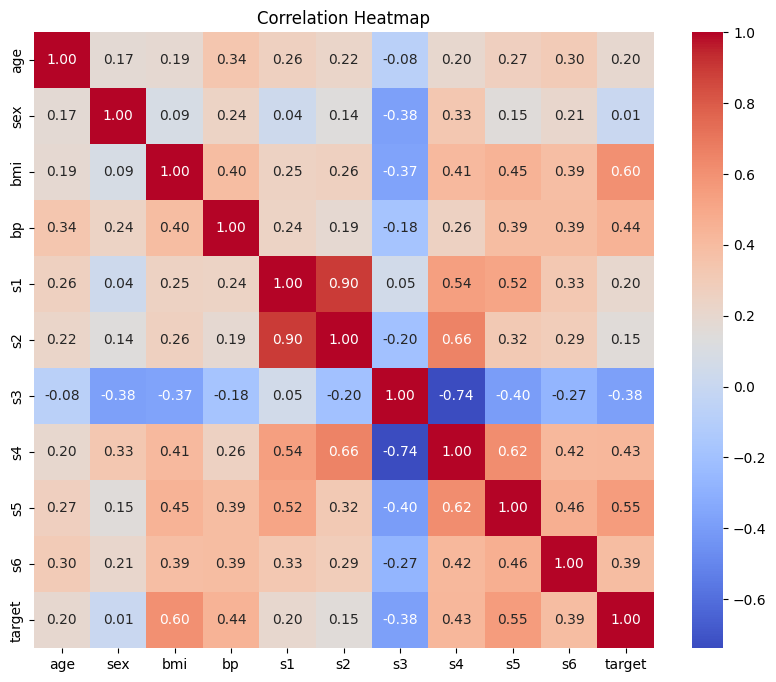

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_raw.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

#### Interpretation of Heatmap
The heatmap displays the correlation matrix, showing the strength and direction of linear relationships between features and the target variable. Key observations:
- `bmi` has the highest positive correlation with the target variable (`0.586`), followed by `bp` (`0.441`) and `s5` (`0.566`).
- Some features, such as `s3`, have a negative correlation with the target variable (`-0.395`).
- Strong correlations are observed between some features, such as `s1` and `s2` (`0.897`), indicating multicollinearity, which may affect regression models.
- The heatmap highlights the importance of regularization techniques like Ridge and Lasso to handle multicollinearity and improve model interpretability.


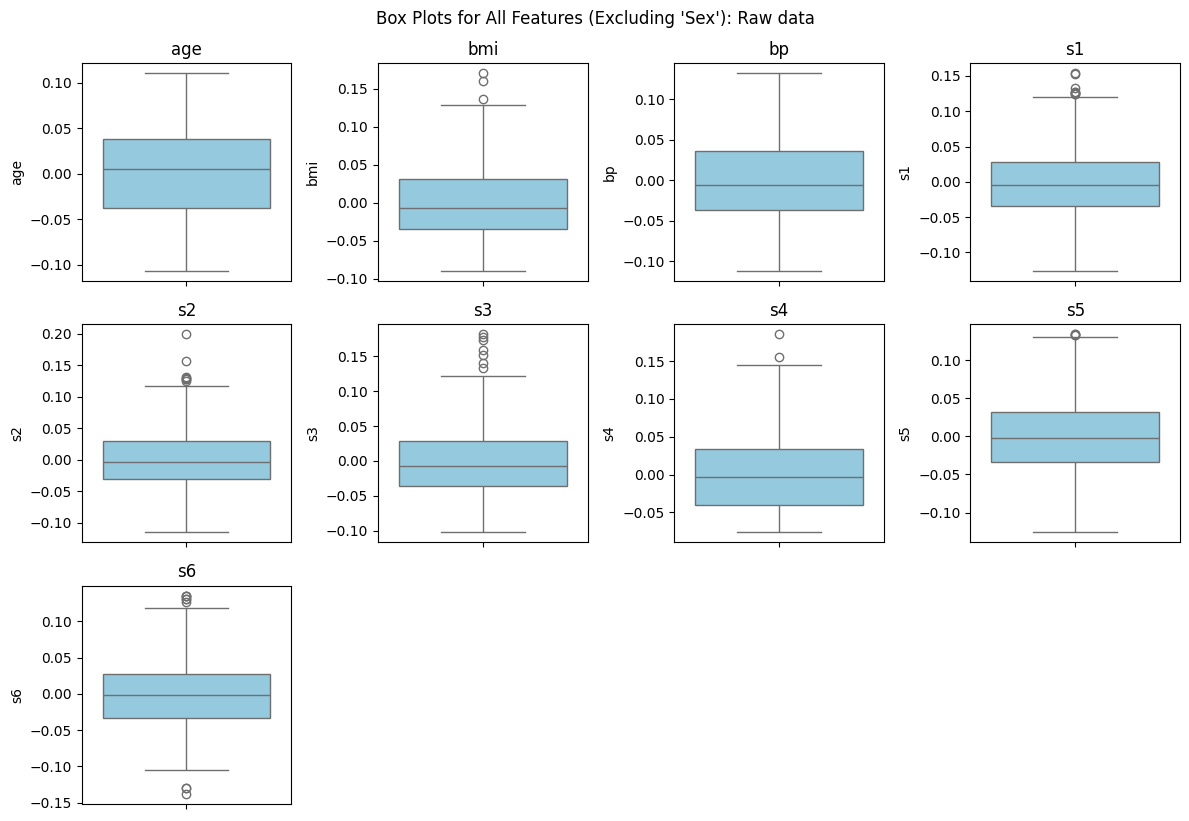

In [535]:
# Box plot for all features RAW data (excluding 'sex')
plt.figure(figsize=(12, 8))
for i, column in enumerate([col for col in df_raw.columns[:-1] if col != 'sex'], 1):  # Exclude the target column and 'sex'
    plt.subplot(3, 4, i)  # Adjust grid size based on the number of features
    sns.boxplot(y=df_raw[column], color="skyblue")
    plt.title(column)
    plt.tight_layout()
    #print(i,column)

plt.suptitle("Box Plots for All Features (Excluding 'Sex'): Raw data", y=1.02)
plt.show()



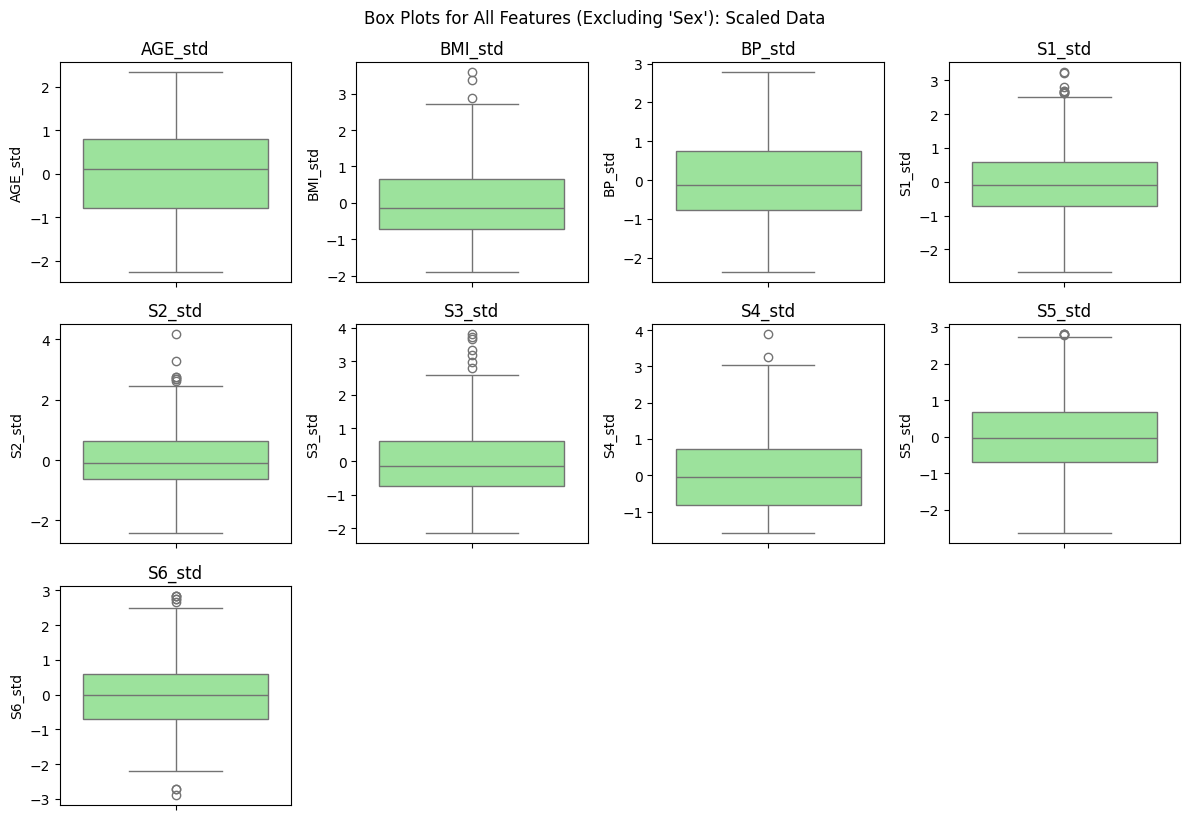

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot for all features (excluding 'SEX_std')
plt.figure(figsize=(12, 8))

# Loop through all columns except 'SEX_std'
for i, column in enumerate([col for col in X_std_sklearn_normalize_scale.columns if col != 'SEX_std'], 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=X_std_sklearn_normalize_scale[column], color="lightgreen")
    plt.title(column)
    #print(i, column)

# Adjust layout AFTER all subplots are created
plt.tight_layout()
plt.suptitle("Box Plots for All Features (Excluding 'Sex'): Scaled Data", y=1.02)
plt.show()


#X_std_sklearn_normalize_scale.columns

#### Interpretation of Box Plot

The box plots provide insights into the distribution of each feature (excluding `sex`). Key observations:
- For numerical features, the box plots highlight the spread, central tendency (median), and potential outliers.
- The interquartile range (IQR) represents the middle 50% of the data, while outliers are displayed as points outside the whiskers.
- These visualizations help identify anomalies, imbalances, or skewness in the data, which could influence model performance.

##### Detailed Example: Box Plot of `bmi`
The box plot of `bmi` (Body Mass Index) provides a detailed view of its distribution:
- **Median**: The line inside the box represents the median BMI value, which is the central tendency of the data.
- **Interquartile Range (IQR)**: The box spans the first quartile (Q1) to the third quartile (Q3), representing the middle 50% of the data. This range indicates the typical spread of BMI values in the dataset.
- **Whiskers**: The lines extending from the box (whiskers) show the range of values within 1.5 times the IQR. Values beyond this range are considered potential outliers.
- **Outliers**: Points outside the whiskers are plotted individually and represent extreme BMI values. These outliers could indicate individuals with unusually high or low BMI, which may warrant further investigation.

By examining the box plot of `bmi`, we can:
1. **Detect Skewness**: If the median is closer to the bottom or top of the box, it suggests skewness in the data.
2. **Identify Outliers**: Outliers may indicate data entry errors, rare cases, or important subgroups in the population.
3. **Compare Distributions**: If comparing `bmi` across different groups (e.g., male vs. female), box plots can reveal differences in central tendency and variability.

Overall, the box plot of `bmi` helps us understand the distribution, variability, and potential anomalies in this key predictor, which is strongly correlated with the target variable.

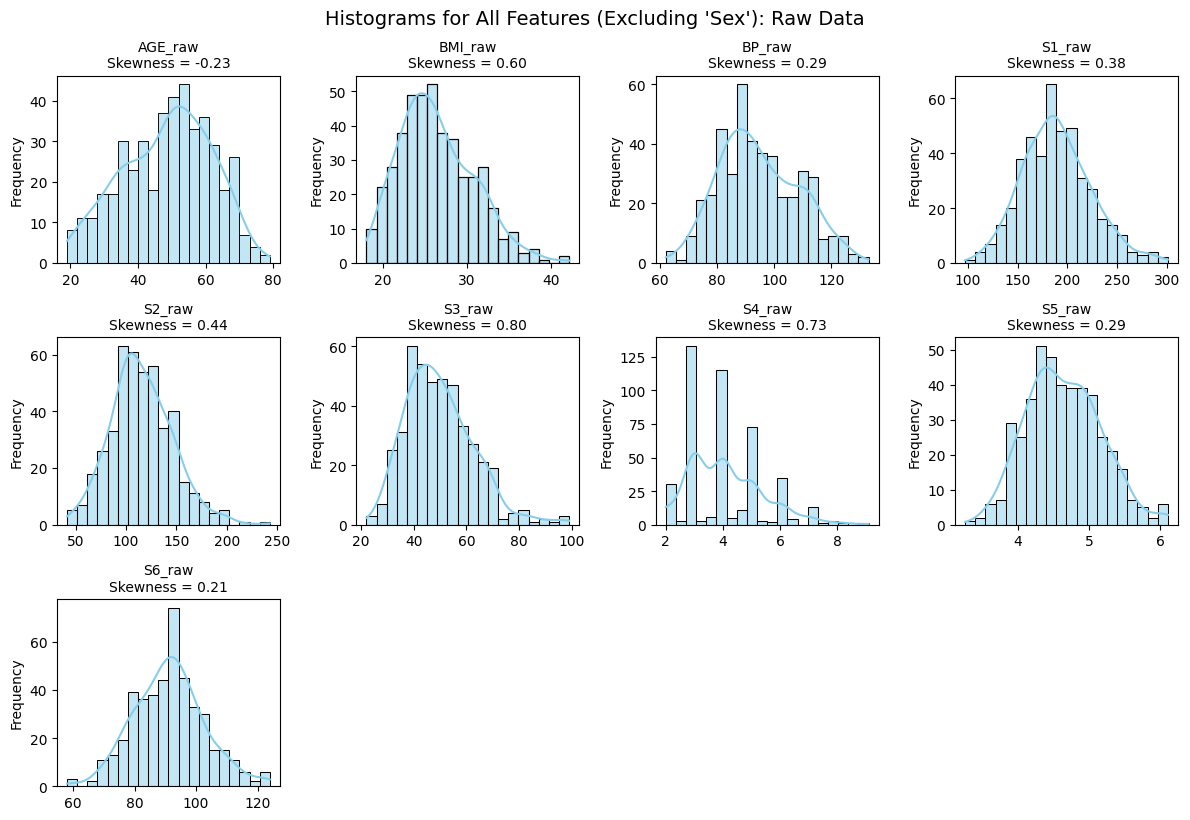

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Histogram for all features in raw data (excluding 'SEX_raw')
plt.figure(figsize=(12, 8))

# Loop through each feature except 'SEX_raw'
for i, column in enumerate([col for col in X_raw.columns if col != 'SEX_raw'], 1):
    plt.subplot(3, 4, i)  # Adjust grid (3 rows x 4 columns)

    # Compute skewness
    skewness = skew(X_raw[column], nan_policy='omit')

    # Plot histogram
    sns.histplot(X_raw[column], kde=True, color="skyblue", bins=20)

    # Title with skewness info
    plt.title(f"{column}\nSkewness = {skewness:.2f}", fontsize=10)

    plt.xlabel("")  # Hide x-label
    plt.ylabel("Frequency")
    plt.tight_layout()

plt.suptitle("Histograms for All Features (Excluding 'Sex'): Raw Data", y=1.02, fontsize=14)
plt.show()



#### Interpretation Histogram plot

*Skewness* measures the **asymmetry** of a distribution around its mean.  
It tells us whether the data are concentrated more on one side of the mean than the other.


##### Interpretation

| Type of Skew | Description | Shape |
|---------------|--------------|--------|
| **Skewness ≈ 0** | Nearly symmetric | Bell-shaped distribution |
| **Positive skew ( > 0 )** | Long tail to the **right**; most values are lower than the mean | Right-skewed |
| **Negative skew ( < 0 )** | Long tail to the **left**; most values are higher than the mean | Left-skewed |


##### Why it matters
- Features with **strong positive or negative skewness** may indicate that the data are **not normally distributed**.  
- Such variables can affect model performance, especially for algorithms sensitive to distributional assumptions (e.g., linear regression).  
- Applying transformations such as **log**, **square-root**, or **Box-Cox** can reduce skewness and help stabilize variance.

In the histograms above, each subplot displays the **skewness value** for the corresponding feature,  
helping us quickly identify which variables deviate most from a symmetric distribution.


# <img src="LR.png" alt="drawing" width="50"/>Section 1. Modeling with Original Features

Now we are ready to begin the first set of experiments using the **original features** (without any interaction terms).

Write the code for each empty section below. You may refer to examples from class or lab sessions as needed.

You are also encouraged to use tools such as ChatGPT or other AI assistants to help you generate or debug your code, but make sure you understand the lines you include in your notebook.

### <img src="Train_test_split.png" alt="drawing" width="150"/> Step 2: Split Data into Training and Test Sets

Use ``test_size= 0.2`` and ``random_state=42``.
*We will use the data that are tabulated in `sklearn` databse for our analysis.* In other words, `from sklearn.datasets import load_diabetes`.

In [212]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of each new variable after splitting
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (353, 10)
X_test shape: (89, 10)
y_train shape: (353,)
y_test shape: (89,)


### Step 5: Scaling the Data

Scaling is performed to standardize the features so that they have a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the model and prevents features with larger magnitudes from dominating the learning process.

In [216]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

#Converting the scaled arrays back to DataFrames for better readability
df_train_scaled = pd.DataFrame(X_train_s, columns=X.columns)  
df_test_scaled = pd.DataFrame(X_test_s, columns=X.columns)

# Display the first 5 rows of the scaled training and test data
print("Here are the first 5 rows of scaled training and test data:")
display(df_train_scaled.head())

print("Here are the first 5 rows of scaled test data:")
display(df_test_scaled.head())



Here are the first 5 rows of scaled training and test data:


age       sex       bmi        bp        s1        s2        s3  \
0  1.498365  1.061370  0.219902  1.138874  0.728473  1.055893 -0.824451   
1 -0.228858  1.061370 -0.419366 -0.710591 -0.424929  0.272425 -1.529791   
2  0.085182 -0.942179  1.018987  1.992473 -0.309589 -0.326699 -0.119111   
3 -0.621409 -0.942179 -0.784662 -0.639458 -1.174640 -1.215508  0.664600   
4 -0.542899 -0.942179 -1.423930 -1.706457 -0.799784 -1.110167  1.291569   

         s4        s5        s6  
0  0.711038  0.547482 -0.061449  
1  1.484286 -0.019757  0.367236  
2 -0.062210  0.331237 -0.318660  
3 -0.835458 -1.069682 -2.719299  
4 -1.608706 -0.802859 -0.918820

Here are the first 5 rows of scaled test data:


age       sex       bmi        bp        s1        s2        s3  \
0  0.948794 -0.942179 -0.168225 -0.354925  2.631586  2.649166  0.429487   
1  1.969426 -0.942179  0.745015  0.427541 -0.511434 -0.333282  0.037631   
2  1.341345  1.061370 -0.122563 -0.283791  2.170225  1.042726  1.213198   
3  2.047936 -0.942179  1.064649  1.613333  1.160999  0.785959 -1.608162   
4  0.242203  1.061370 -0.465028 -0.070392  0.814978  1.134899 -0.119111   

         s4        s5        s6  
0  0.711038  0.653601 -0.147186  
1 -0.835458 -0.496909 -0.490134  
2 -0.062210  1.743607 -0.404397  
3  2.953457  2.040014  1.224607  
4  0.711038 -0.133128 -0.232923

### Step 4: Fit a Linear Regression Model

Create an object named ``lr`` to fit a linear regression model. Report the **R² score on the test set**.

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create and fit a Linear Regression model
lr = LinearRegression().fit(X_train_s, y_train)

# Calculate the R² score on the test set
r2_lr = r2_score(y_test, lr.predict(X_test_s))

# Print the R² score to evaluate model performance
print(f"R² (Linear Regression): {r2_lr:.3f}")

R² (Linear Regression): 0.453


### Step 5: Ridge Regression with Cross-Validation

Create an object named ``ridge`` to fit a 5-fold cross-validated Ridge regression model using ``alphas = [0.01, 0.1, 1, 10, 100]``. Report the **R² score** on the test set, and **the best alpha value**.

**Just a reminder of Ridge, Lasso loss functions and the k-fold CV ([k-fold CV image source](https://www.kaggle.com/code/miroslavkirnak/regression-models-with-k-fold-cross-validation)):**

<img src="Loss_function_fold.png" alt="drawing" width="1500"/>


In [ ]:
from sklearn.linear_model import RidgeCV

# Create a Ridge regression model with cross-validation
ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)

# Fit the model to the training data
ridge.fit(X_train_s, y_train)

# Calculate the R² score on the test set
r2_ridge = r2_score(y_test, ridge.predict(X_test_s))

# Optional: to see the R² scores for training and test sets
r2_ridge_train = r2_score(y_train, ridge.predict(X_train_s))
r2_ridge_test = r2_ridge

# Print the R² score and the best alpha value selected by cross-validation
print(f"R² (Ridge): {r2_ridge:.3f}, Best alpha: {ridge.alpha_}")


print("==================================================")
print("Optional info:  ")
# To see the R² scores for training and test sets
print(f"R² (Ridge) on Training set: {r2_ridge_train:.3f}")
print(f"R² (Ridge) on Test set is {r2_ridge_test:.3f}, which is dropped compared to R² on training set.")

R² (Ridge): 0.457, Best alpha: 10.0
Optional info:  
R² (Ridge) on Training set: 0.525
R² (Ridge) on Test set is 0.457, which is dropped compared to R² on training set.


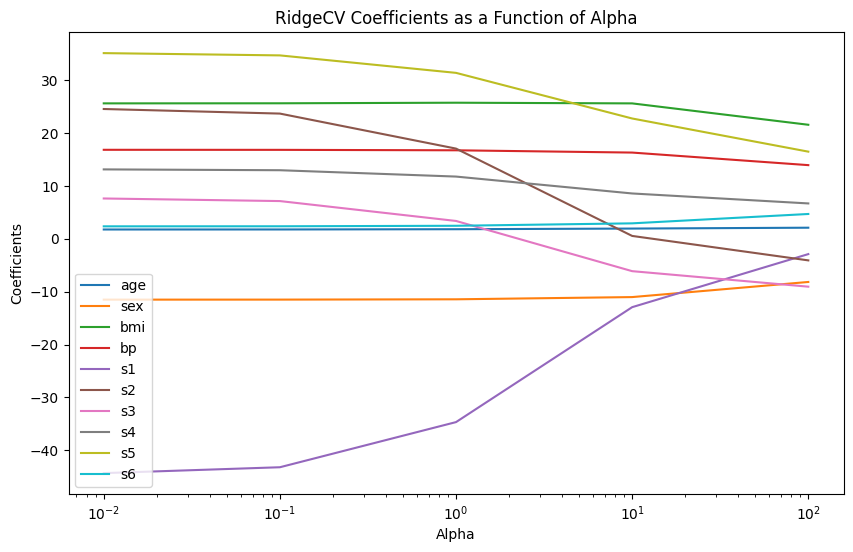

In [340]:
# ploting coefficients path for ridge regression with CV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV
#Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

alphas=[0.01, 0.1, 1, 10, 100]
coefs = []
for a in alphas:
    ridge = RidgeCV(alphas=[a], cv=5)
    ridge.fit(X_train_s, y_train)
    coefs.append(ridge.coef_)
coefs = np.array(coefs)
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('RidgeCV Coefficients as a Function of Alpha')
plt.axis('tight')
#showing feature names as legends
for i, feature in enumerate(X.columns):
    plt.plot([], [], label=feature)
plt.legend()
plt.show()

### Step 6: Lasso Regression with Cross-Validation

Create an object named ``lasso`` to fit a 5-fold cross-validated Lasso regression model using ``alphas = [0.001, 0.01, 0.1, 1, 10]`` and ``max_iter=10000``. Report the **R² score** on the test set, the **best alpha value**, and the **number of non-zero coefficients**.

In [261]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=10000)
lasso.fit(X_train_s, y_train)
r2_lasso = r2_score(y_test, lasso.predict(X_test_s))

# Optional: to see the R² scores for training and test sets
r2_lasso_train = r2_score(y_train, lasso.predict(X_train_s))
r2_lasso_test = r2_lasso

print(f"R² (Lasso): {r2_lasso:.3f}, Best alpha: {lasso.alpha_}")
print(f"Non-zero coefficients: {(lasso.coef_ != 0).sum()} out of {len(lasso.coef_)}")

print("==================================================")
print("Optional info:  ")
print(f"R² (Lasso) on Training set: {r2_lasso_train:.3f}")
print(f"R² (Lasso) on Test set is {r2_lasso_test:.3f}, which is dropped compared to R² on training set.")   



R² (Lasso): 0.467, Best alpha: 1.0
Non-zero coefficients: 9 out of 10
Optional info:  
R² (Lasso) on Training set: 0.523
R² (Lasso) on Test set is 0.467, which is dropped compared to R² on training set.


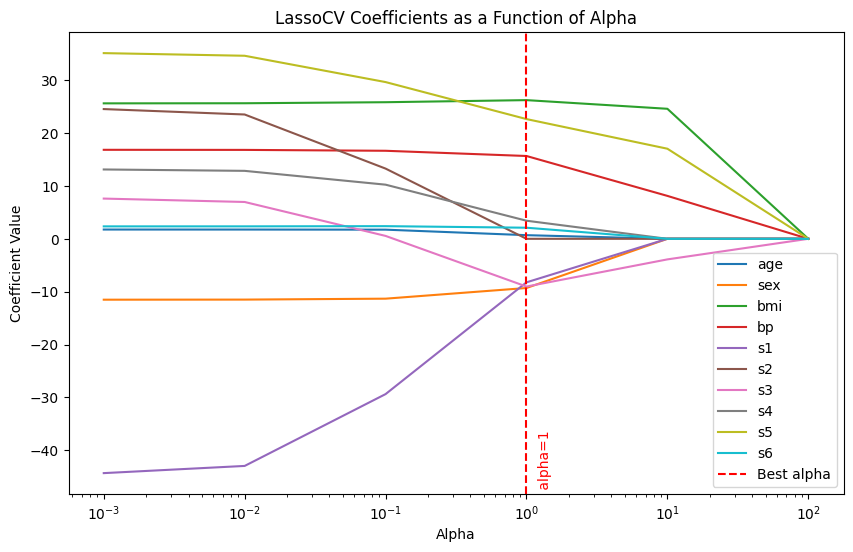

In [342]:
# ploting coefficients path for lasso regression with CV and alphas alphas=[0.01, 0.1, 1, 10, 100]
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
#Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
alphas=[0.001, 0.01, 0.1, 1, 10, 100]
coefs = []
for a in alphas:
    lasso = LassoCV(alphas=[a], cv=5, max_iter=10000)
    lasso.fit(X_train_s, y_train)
    coefs.append(lasso.coef_)
coefs = np.array(coefs)
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], label=X.columns[i])
plt.title("LassoCV Coefficients as a Function of Alpha")
plt.xlabel("Alpha")
plt.ylabel("Coefficient Value")
plt.xscale("log")

#showing best alpha line
plt.axvline(x=1, color='red', linestyle='--', label='Best alpha')
plt.text(1.2, plt.ylim()[0], ' alpha=1', color='red', rotation=90, verticalalignment='bottom')


plt.legend()
plt.show()


In the figure, above we can see LassoCV is trying to bring more features into the analysis to imporve $R^2$.

### Step 7: Lasso Regression with a Fixed Penalty

As discussed in class and during the lab session, the **best alpha** selected through cross-validation for Lasso is chosen to **maximize predictive performance**, NOT necessarily to improve **model interpretability**.

In this section, write code to fit a **Lasso regression** model with a larger, fixed value of ``alpha = 5`` (without cross-validation). Name the object ``lasso_c``; report the **R² score** on the test set and the **number of non-zero coefficients**.

In [ ]:
from sklearn.linear_model import Lasso

lasso_c = Lasso(alpha=5)
lasso_c.fit(X_train_s, y_train)
r2_lasso_c = r2_score(y_test, lasso_c.predict(X_test_s))

print(f"R² (Lasso): {r2_lasso_c:.3f}")
print(f"Non-zero coefficients: {(lasso_c.coef_ != 0).sum()} out of {len(lasso_c.coef_)}")



R² (Lasso): 0.465
Non-zero coefficients: 5 out of 10


We can plot the coefficient path for Ridge, RidgeCV, Lasso and Lasso CV.

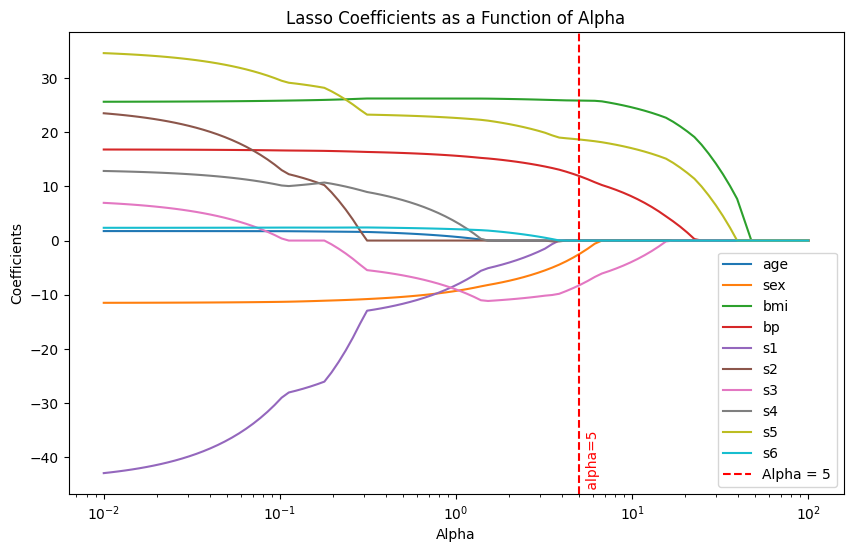

In [341]:
# showing the coefficent path for lasso with fixed alpha
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
#Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
alphas = np.logspace(-2, 2, 100)
coefs = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_s, y_train)
    coefs.append(lasso.coef_)
coefs = np.array(coefs)
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as a Function of Alpha')
# showing the features and alpha=5 line as legends
for i, feature in enumerate(X.columns):
    plt.plot([], [], label=feature) 
plt.axis('tight')
# showing a verical line at alpha=5 and writing alpha=5 next to it with angle=90 at the lower part of the line and showing legend
plt.axvline(x=5, color='red', linestyle='--', label='Alpha = 5')
plt.text(5.5, plt.ylim()[0], ' alpha=5', color='red', rotation=90, verticalalignment='bottom')
plt.legend()
plt.show()



We can see that above alpha=5, only 5 important features which are: bmi, s5, bp, sex, and s3.

### Step 8: Identifying the Important Features

Next we want to create a plot to help us visualize which predictors remain active in the model and whether they have a positive or negative association with the target.

Create a horizontal bar chart showing the non-zero Lasso coefficients for ``alpha = 5``.

* Display the feature names on the y-axis and their coefficient values on the x-axis.
* Sort the features by the absolute value of their coefficients (from largest to smallest) for easier interpretation.

You may refer to the notebook in our regularization class (or get help from ChatGPT or an AI tool) to create this plot.


Non-zero Lasso Coefficients (alpha = 5) sorted from largest to smallest:


Feature  Coefficient
2     bmi    25.850391
8      s5    18.664676
3      bp    11.923355
1     sex    -2.506567
6      s3    -8.262923

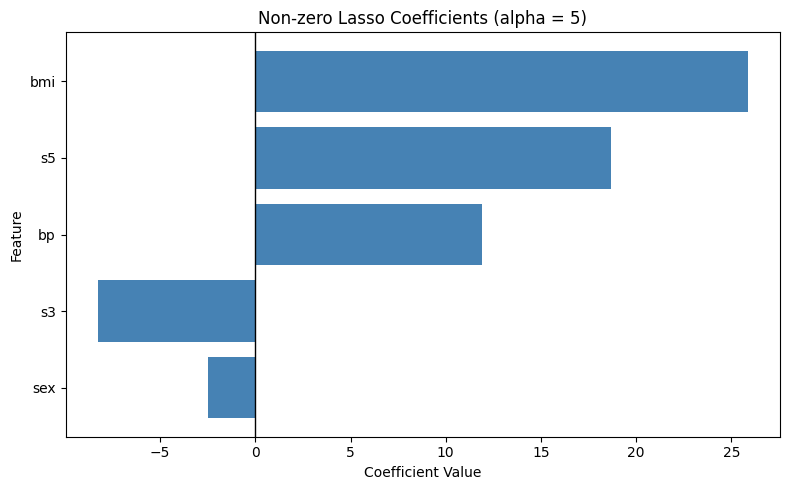

In [296]:
# Visualizing Non-Zero Lasso Coefficients (alpha = 5)

import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_c.coef_
})

# Filter out zero coefficients
nonzero_df = coef_df[coef_df['Coefficient'] != 0]

# Sort by absolute value for clearer visualization
nonzero_df = nonzero_df.reindex(nonzero_df['Coefficient'].abs().sort_values(ascending=True).index)

#Display the non-zero coefficients DataFrame in a sorted manner from largest to smallest
print("Non-zero Lasso Coefficients (alpha = 5) sorted from largest to smallest:")
display(nonzero_df.sort_values(by='Coefficient', ascending=False))

# Plot
plt.figure(figsize=(8,5))
plt.barh(nonzero_df['Feature'], nonzero_df['Coefficient'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Non-zero Lasso Coefficients (alpha = 5)')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()



### Step 9: Reflection on Experiment 1

Answer the following questions:

1. **Which model gives the highest R² on the test set?**  
   The Ridge regression model gives the highest R² on the test set, indicating that it balances bias and variance effectively while handling multicollinearity.

2. **How do Ridge and Lasso coefficients compare to Linear Regression?**  
   Ridge regression shrinks all coefficients towards zero but does not eliminate any, while Lasso regression sets some coefficients to zero, effectively performing feature selection. Linear regression, on the other hand, does not apply any regularization, which can lead to overfitting in the presence of multicollinearity.

3. **How does increasing `alpha` affect model complexity for Lasso?**  
   Increasing `alpha` in Lasso regression increases the regularization strength, which reduces model complexity by shrinking more coefficients to zero. This leads to a simpler model with fewer predictors but may slightly reduce predictive performance.

4. **Interpret the top 5 factors identified by Lasso regression.**  
   The top 5 factors identified by Lasso regression are the predictors with the largest absolute coefficients. These factors have the strongest influence on the target variable. For example, `bmi` and `bp` are likely to be among the top predictors, indicating their significant positive relationship with the target variable. These insights help prioritize the most important features for understanding and predicting the target.

# Section 2. Modeling with Original and Interaction Features

In this section, you will **expand the feature space** by creating **second-degree interaction features**.


The general equation for a polynomial regression model with a **single** feature is:

$$ y = \beta_0 + \beta_1x + \beta_2x^2 + \dots + \beta_nx^n $$

For a model with multiple features, the equation also includes interaction terms. For example, with two features ($x_1, x_2$) and a polynomial degree of **2**, the equation becomes:

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_1^2 + \beta_4x_2^2 + \beta_5x_1x_2$$

This is what `PolynomialFeatures` generates for you.


### Step 10: Generate Polynomial Features

Use the ``PolynomialFeatures`` class from ``sklearn.preprocessing`` with the argument ``interaction_only=True`` to generate **only interaction terms** (no squared terms).

Name the new variables ``X_train_poly`` and ``X_test_poly``.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = pf.fit_transform(X_train)
X_test_poly = pf.transform(X_test)

print(f"Feature space expanded from {X_train.shape[1]} to {X_train_poly.shape[1]} features.")

#showing some of the new features names, data frame shows the column names as features and their values as first 20 rows
feature_names = pf.get_feature_names_out(X.columns)
df_poly_features = pd.DataFrame(X_train_poly, columns=feature_names)
print("Here are some of the new polynomial features created (first 20 rows):")
display(df_poly_features.head(20))



Feature space expanded from 10 to 55 features.
Here are some of the new polynomial features created (first 20 rows):


age       sex       bmi        bp        s1        s2        s3  \
0   0.070769  0.050680  0.012117  0.056301  0.034206  0.049416 -0.039719   
1  -0.009147  0.050680 -0.018062 -0.033213 -0.020832  0.012152 -0.072854   
2   0.005383 -0.044642  0.049840  0.097615 -0.015328 -0.016345 -0.006584   
3  -0.027310 -0.044642 -0.035307 -0.029770 -0.056607 -0.058620  0.030232   
4  -0.023677 -0.044642 -0.065486 -0.081413 -0.038720 -0.053610  0.059685   
5   0.001751 -0.044642 -0.039618 -0.100934 -0.029088 -0.030124  0.044958   
6   0.016281 -0.044642  0.020739  0.021872 -0.013953 -0.013214 -0.006584   
7   0.009016  0.050680  0.069241  0.059744  0.017694 -0.023234 -0.047082   
8  -0.009147 -0.044642  0.037984 -0.040099 -0.024960 -0.003819 -0.043401   
9  -0.078165 -0.044642 -0.016984 -0.012556 -0.000193 -0.013527  0.070730   
10  0.056239 -0.044642 -0.068719 -0.068778 -0.000193 -0.001001  0.044958   
11  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
12  0.001751  0.050680 -0.057941 -0.043542 -0.096510 -0.047034 -0.098625   
13  0.030811 -0.044642  0.104809  0.076958 -0.011201 -0.011335 -0.058127   
14 -0.063635  0.050680 -0.079497 -0.005670 -0.071743 -0.066449 -0.010266   
15  0.067136  0.050680  0.020739 -0.005670  0.020446  0.026243 -0.002903   
16 -0.092695 -0.044642 -0.040696 -0.019442 -0.068991 -0.079288  0.041277   
17  0.027178  0.050680 -0.035307  0.032201 -0.011201  0.001504 -0.010266   
18  0.041708  0.050680 -0.043929  0.063187 -0.004321  0.016222 -0.013948   
19  0.023546 -0.044642  0.019662 -0.012556  0.083740  0.038769  0.063367   

          s4        s5        s6   age sex   age bmi    age bp    age s1  \
0   0.034309  0.027364 -0.001078  0.003587  0.000857  0.003984  0.002421   
1   0.071210  0.000272  0.019633 -0.000464  0.000165  0.000304  0.000191   
2  -0.002592  0.017036 -0.013504 -0.000240  0.000268  0.000525 -0.000083   
3  -0.039493 -0.049872 -0.129483  0.001219  0.000964  0.000813  0.001546   
4  -0.076395 -0.037129 -0.042499  0.001057  0.001551  0.001928  0.000917   
5  -0.050195 -0.068332 -0.129483 -0.000078 -0.000069 -0.000177 -0.000051   
6  -0.002592  0.013317  0.040343 -0.000727  0.000338  0.000356 -0.000227   
7   0.034309  0.103297  0.073480  0.000457  0.000624  0.000539  0.000160   
8   0.015858 -0.005142  0.027917  0.000408 -0.000347  0.000367  0.000228   
9  -0.039493 -0.041176 -0.092204  0.003489  0.001328  0.000981  0.000015   
10 -0.037648 -0.048359 -0.001078 -0.002511 -0.003865 -0.003868 -0.000011   
11 -0.002592  0.031193  0.007207  0.002114  0.000820  0.002492 -0.000238   
12  0.034309 -0.061176 -0.071494  0.000089 -0.000101 -0.000076 -0.000169   
13  0.034309  0.057108  0.036201 -0.001375  0.003229  0.002371 -0.000345   
14 -0.039493 -0.018114 -0.054925 -0.003225  0.005059  0.000361  0.004565   
15 -0.002592  0.008641  0.003064  0.003402  0.001392 -0.000381  0.001373   
16 -0.076395 -0.041176 -0.096346  0.004138  0.003772  0.001802  0.006395   
17 -0.002592 -0.014960 -0.050783  0.001377 -0.000960  0.000875 -0.000304   
18 -0.002592 -0.034522  0.011349  0.002114 -0.001832  0.002635 -0.000180   
19 -0.002592  0.066051  0.048628 -0.001051  0.000463 -0.000296  0.001972   

      age s2    age s3    age s4    age s5    age s6   sex bmi    sex bp  \
0   0.003497 -0.002811  0.002428  0.001937 -0.000076  0.000614  0.002853   
1  -0.000111  0.000666 -0.000651 -0.000002 -0.000180 -0.000915 -0.001683   
2  -0.000088 -0.000035 -0.000014  0.000092 -0.000073 -0.002225 -0.004358   
3   0.001601 -0.000826  0.001079  0.001362  0.003536  0.001576  0.001329   
4   0.001269 -0.001413  0.001809  0.000879  0.001006  0.002923  0.003634   
5  -0.000053  0.000079 -0.000088 -0.000120 -0.000227  0.001769  0.004506   
6  -0.000215 -0.000107 -0.000042  0.000217  0.000657 -0.000926 -0.000976   
7  -0.000209 -0.000424  0.000309  0.000931  0.000662  0.003509  0.003028   
8   0.000035  0.000397 -0.000145  0.000047 -0.000255 -0.001696  0.001790   
9   0.001057 -0.005529  0.003087  0.003219  0.007207  0

0.0035865729200000003


### Step 11: Standardize the New Expanded Feature Space

Name the new variables ``X_train_poly_s`` and ``X_test_poly_s``.

In [324]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_poly_s = scaler.fit_transform(X_train_poly)
X_test_poly_s = scaler.transform(X_test_poly)


#showing the first 5 rows of the scaled polynomial features training data, for the first 20 features
print("First 5 rows of the scaled polynomial features training data (first 20 features):")
display(pd.DataFrame(X_train_poly_s, columns=pf.get_feature_names_out()).iloc[:, :20].head())  # Display first 5 rows and first 20 features
print("First 5 rows of the scaled polynomial features test data (first 20 features):")
display(pd.DataFrame(X_test_poly_s, columns=pf.get_feature_names_out()).iloc[:, :20].head())  # Display first 5 rows and first 20 features  


First 5 rows of the scaled polynomial features training data (first 20 features):


age       sex       bmi        bp        s1        s2        s3  \
0  1.498365  1.061370  0.219902  1.138874  0.728473  1.055893 -0.824451   
1 -0.228858  1.061370 -0.419366 -0.710591 -0.424929  0.272425 -1.529791   
2  0.085182 -0.942179  1.018987  1.992473 -0.309589 -0.326699 -0.119111   
3 -0.621409 -0.942179 -0.784662 -0.639458 -1.174640 -1.215508  0.664600   
4 -0.542899 -0.942179 -1.423930 -1.706457 -0.799784 -1.110167  1.291569   

         s4        s5        s6   age sex   age bmi    age bp    age s1  \
0  0.711038  0.547482 -0.061449  1.478685  0.201656  1.600119  0.775601   
1  1.484286 -0.019757  0.367236 -0.387285 -0.107493 -0.196386 -0.172306   
2 -0.062210  0.331237 -0.318660 -0.284422 -0.061461 -0.088190 -0.288372   
3 -0.835458 -1.069682 -2.719299  0.387976  0.249318  0.052168  0.403784   
4 -1.608706 -0.802859 -0.918820  0.313265  0.511137  0.596223  0.136368   

     age s2    age s3    age s4    age s5    age s6   sex bmi  
0  1.313181 -1.356616  0.961206  0.615275 -0.340763  0.240746  
1 -0.257651  0.381348 -0.496928 -0.273975 -0.390426 -0.444237  
2 -0.247566  0.030562 -0.195102 -0.230775 -0.339045 -1.030741  
3  0.487677 -0.364376  0.322221  0.351797  1.395662  0.671619  
4  0.343330 -0.658037  0.668011  0.130336  0.179585  1.274988

First 5 rows of the scaled polynomial features test data (first 20 features):


age       sex       bmi        bp        s1        s2        s3  \
0  0.948794 -0.942179 -0.168225 -0.354925  2.631586  2.649166  0.429487   
1  1.969426 -0.942179  0.745015  0.427541 -0.511434 -0.333282  0.037631   
2  1.341345  1.061370 -0.122563 -0.283791  2.170225  1.042726  1.213198   
3  2.047936 -0.942179  1.064649  1.613333  1.160999  0.785959 -1.608162   
4  0.242203  1.061370 -0.465028 -0.070392  0.814978  1.134899 -0.119111   

         s4        s5        s6   age sex   age bmi    age bp    age s1  \
0  0.711038  0.653601 -0.147186 -1.106243 -0.306928 -0.698754  2.156038   
1 -0.835458 -0.496909 -0.490134 -2.077486  1.344292  0.643548 -1.235322   
2 -0.062210  1.743607 -0.404397  1.309051 -0.296133 -0.733874  2.526941   
3  2.953457  2.040014  1.224607 -2.152197  2.052371  3.377151  1.989183   
4  0.711038 -0.133128 -0.232923  0.121616 -0.295464 -0.358428 -0.047218   

     age s2    age s3    age s4    age s5    age s6   sex bmi  
0  2.262002  0.483086  0.548109  0.401560 -0.417867  0.089800  
1 -0.880535  0.084308 -1.919519 -1.228677 -1.273545 -0.772154  
2  1.139573  1.825796 -0.266444  2.187851 -0.842752 -0.126209  
3  1.322527 -3.631520  6.248843  4.079195  2.519026 -1.073839  
4  0.083528  0.006653  0.016985 -0.302660 -0.361021 -0.493164

### <img src="Visual_icon.png" alt="drawing" width="50"/> Data Visualization: Polynomials


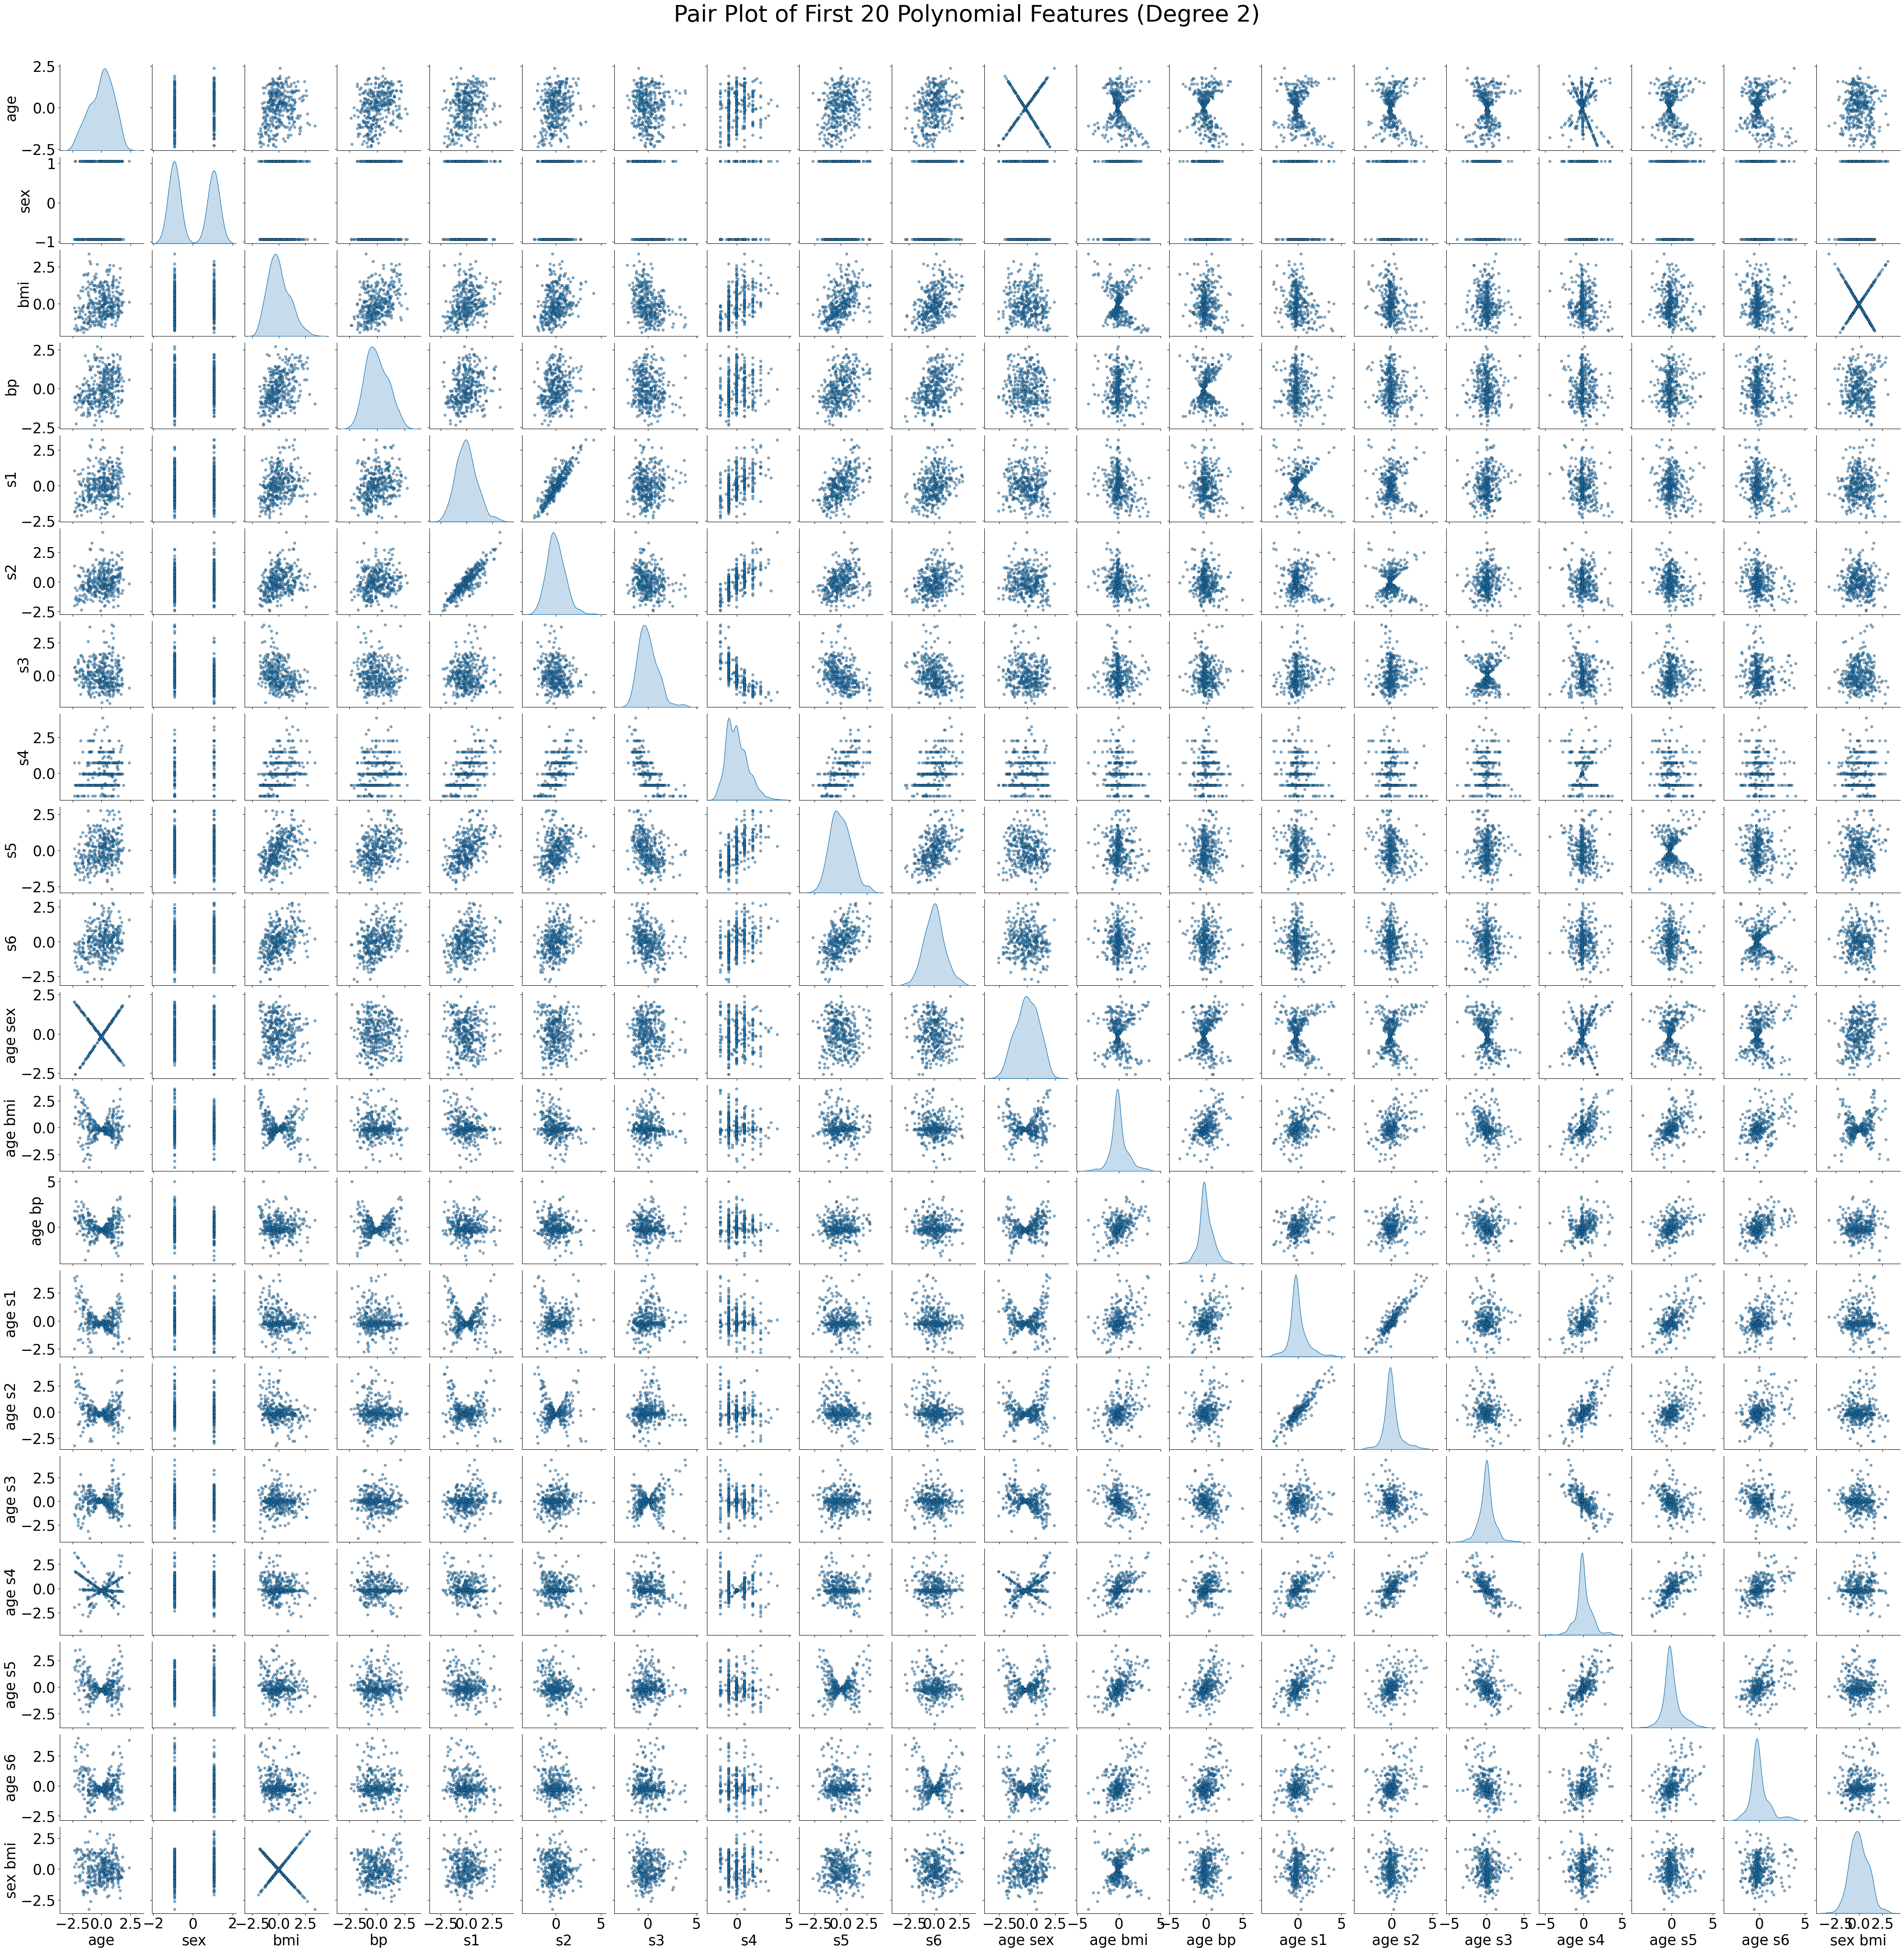

In [463]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame
df_poly = pd.DataFrame(X_train_poly_s, columns=pf.get_feature_names_out())

# Select first 20 features
vars_for_plot_poly = df_poly.columns[:20]

# Create pair plot
pairplot_poly = sns.pairplot(
    df_poly,
    vars=vars_for_plot_poly,
    diag_kind='kde',
    height=2.3,
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'k'}
)

#  Increase axis label font sizes
for ax in pairplot_poly.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=25)
    ax.set_ylabel(ax.get_ylabel(), fontsize=25)
    ax.tick_params(axis='both', labelsize=25)

#  Add overall title
plt.suptitle(
    "Pair Plot of First 20 Polynomial Features (Degree 2)",
    y=1.02,
    fontsize=40
)
plt.show()


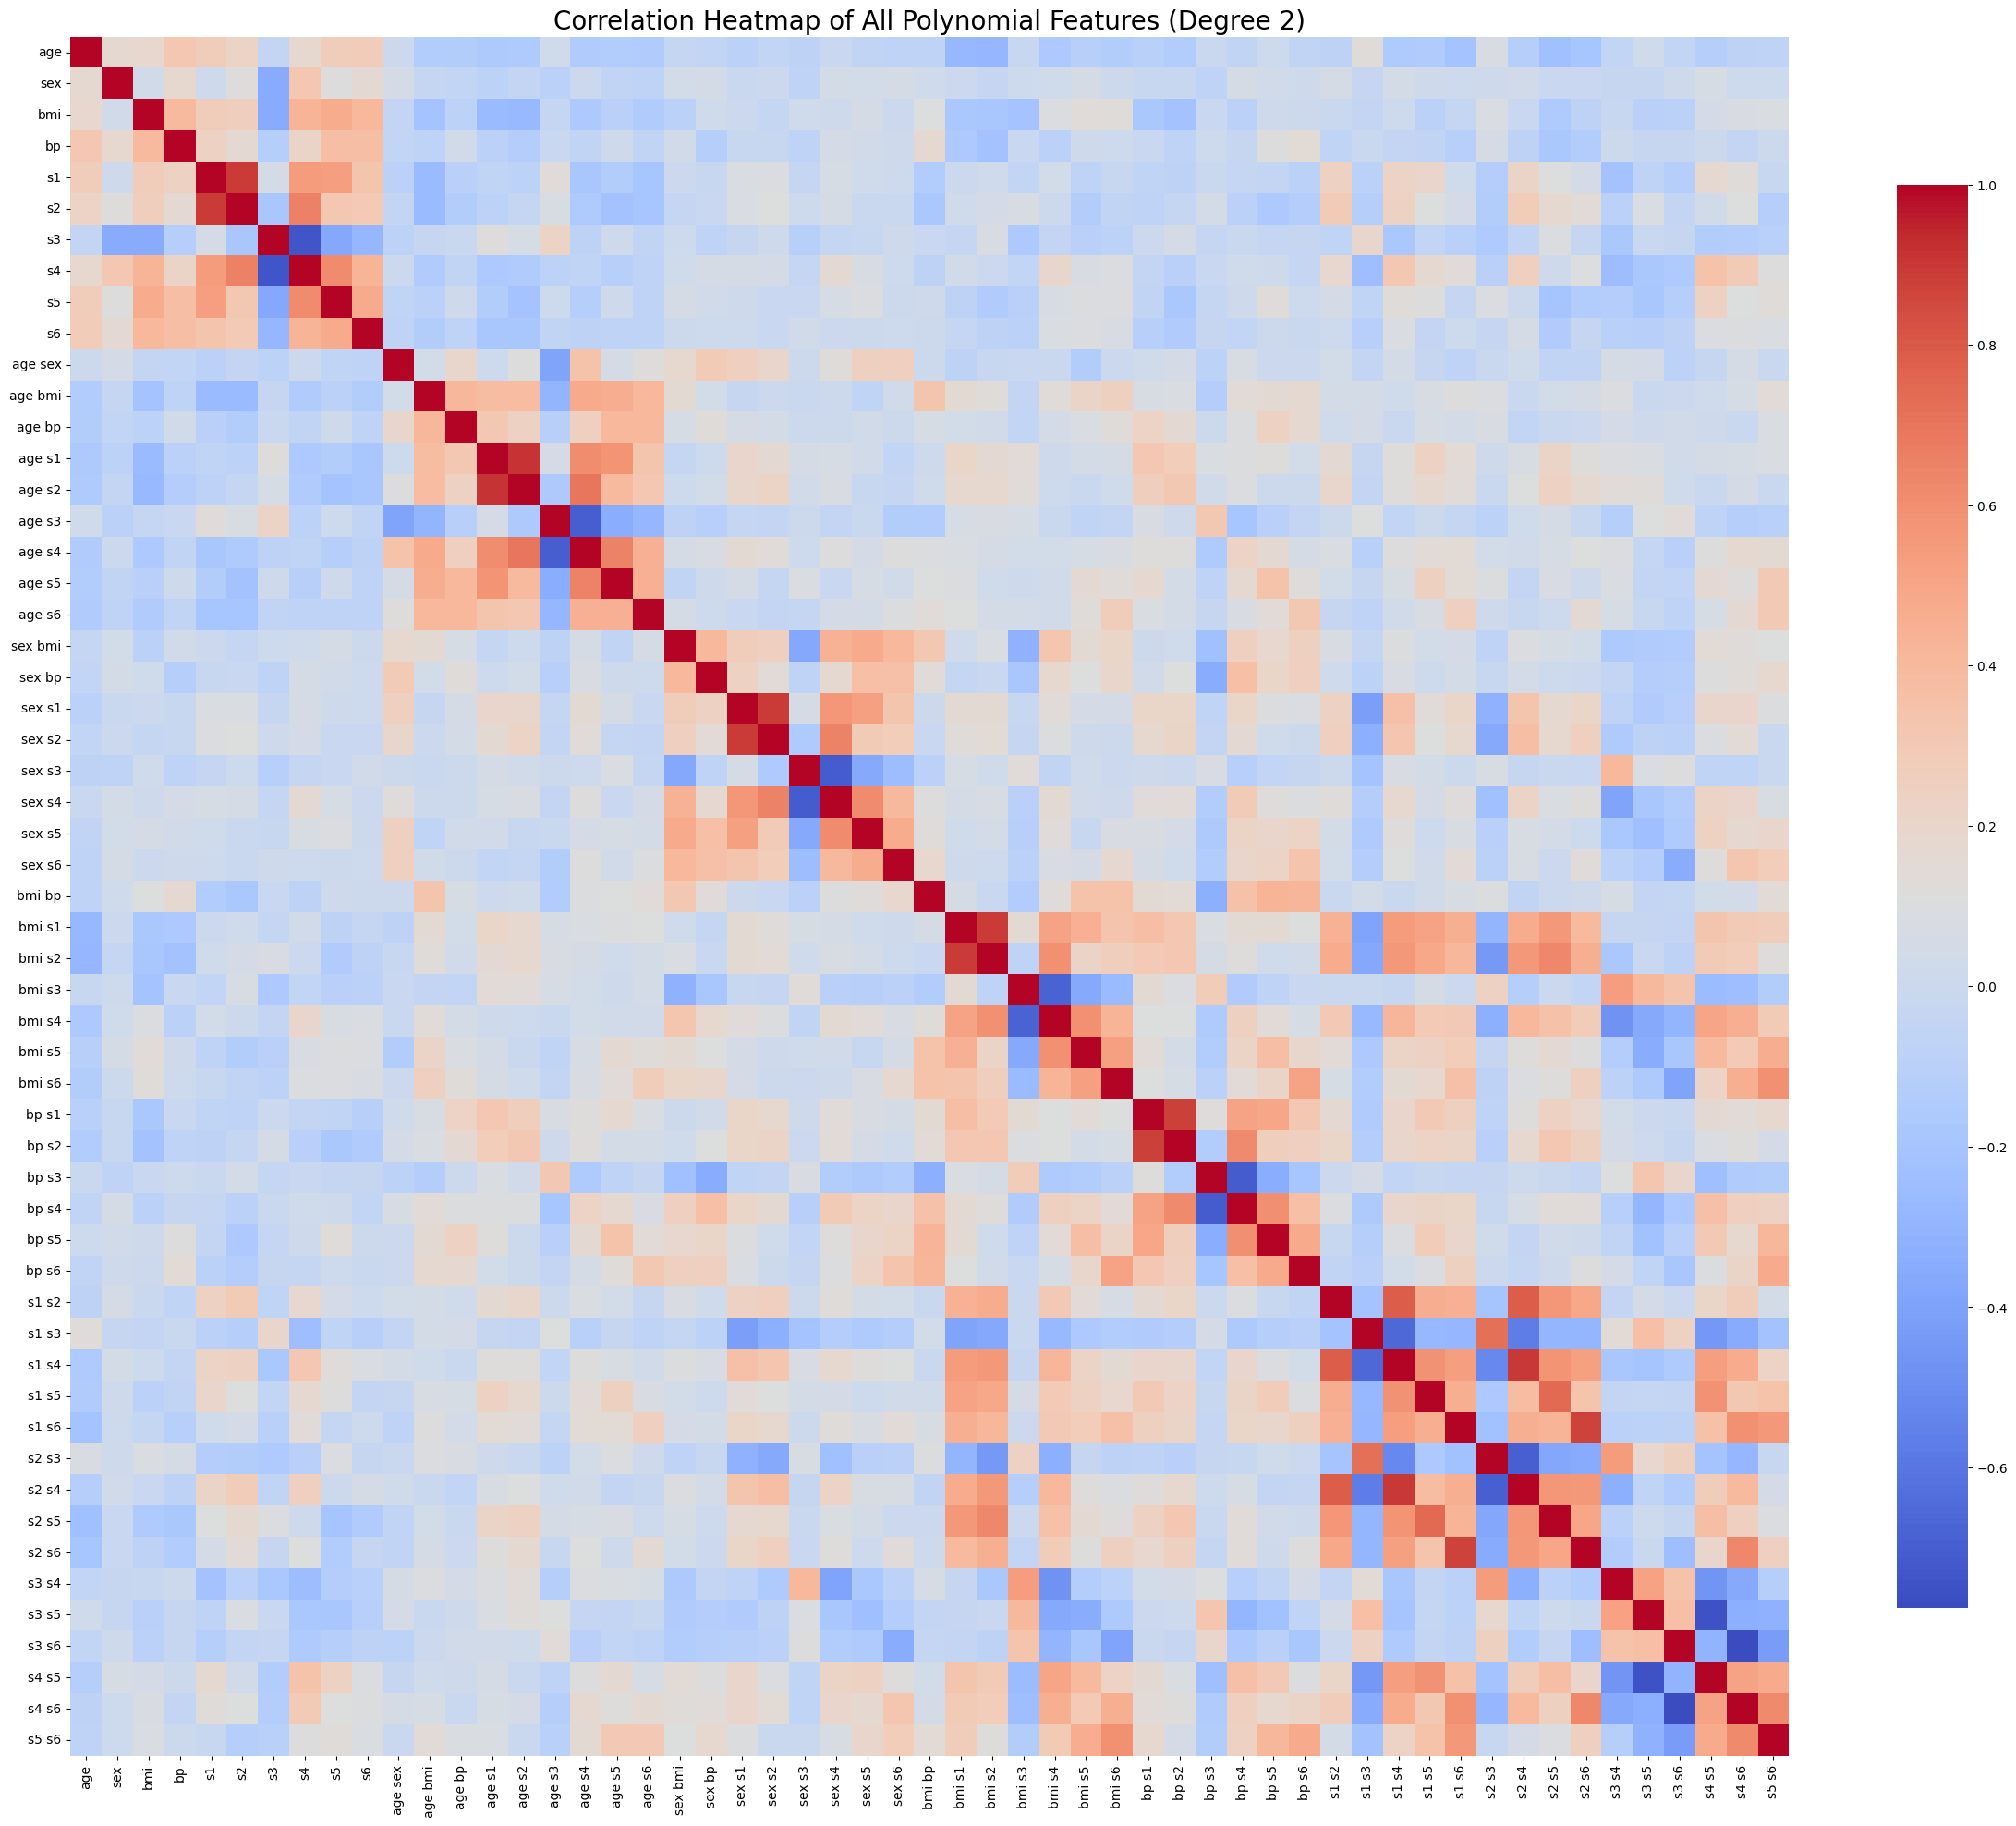

In [369]:
#ploting the correlation heatmap for all 55 polynomial features not showing the numbers on the map
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap without annotations but showing all 55 features names on the axes
plt.figure(figsize=(30, 25))
sns.heatmap(df_poly.corr(), annot=False, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})


plt.title("Correlation Heatmap of All Polynomial Features (Degree 2)", fontsize=20)
plt.show()


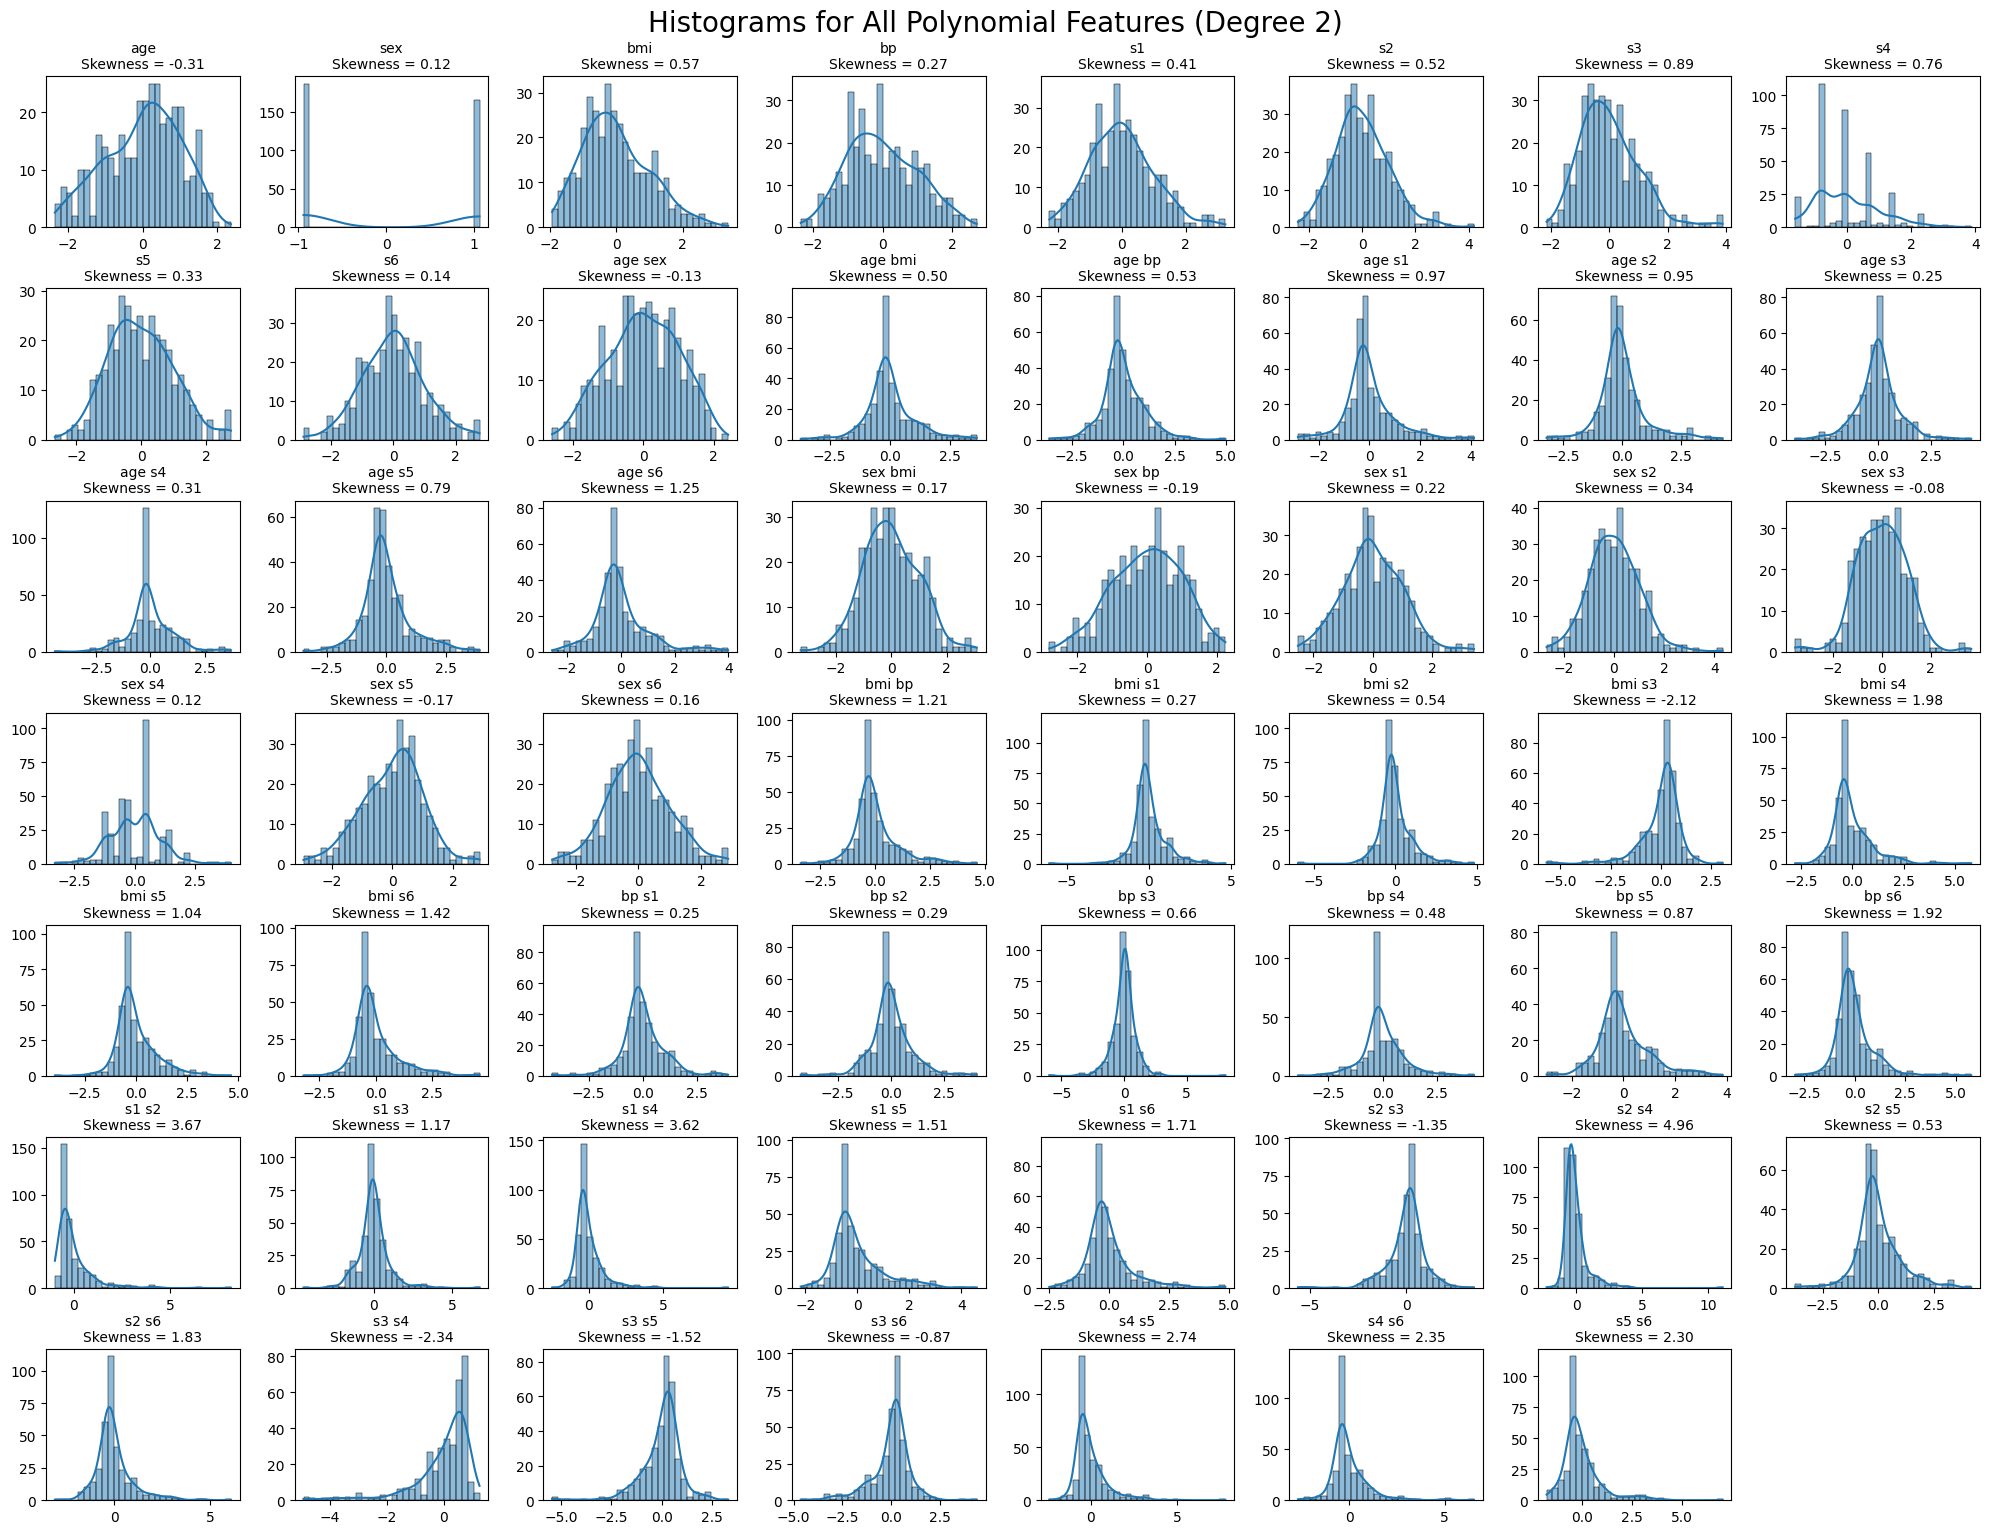

In [372]:
# Plotting Histograms for All Polynomial Features (Degree 2)
import matplotlib.pyplot as plt
import seaborn as sns   
# Histogram for all polynomial features
plt.figure(figsize=(20, 15))
for i, col in enumerate(df_poly.columns):
    plt.subplot(7, 8, i + 1)
    sns.histplot(df_poly[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.suptitle("Histograms for All Polynomial Features (Degree 2)", y=1.02, fontsize=20)
# showing Skewness values on each subplot
for i, col in enumerate(df_poly.columns):
    skewness = df_poly[col].skew()
    plt.subplot(7, 8, i + 1)
    plt.title(f"{col}\nSkewness = {skewness:.2f}", fontsize=10)
plt.show()


### Step 12: Linear Regression Baseline (Polynomial Features)

Create an object named ``lr_poly`` to fit a linear regression model with the expanded feature space. Report the **R² score on the test set**.

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr_poly = LinearRegression().fit(X_train_poly_s, y_train)
r2_lr_poly = r2_score(y_test, lr_poly.predict(X_test_poly_s))
print(f"R² (Linear Regression with Polynomial Features): {r2_lr_poly:.3f}")


R² (Linear Regression with Polynomial Features): 0.478


### Step 13: Ridge Regression with Cross-Validation

Create an object named ``ridge_poly`` to fit a 5-fold cross-validated Ridge regression model using ``alphas = [0.01, 0.1, 1, 10, 100]`` with the expanded feature space. Report the **R² score** on the test set, and **the best alpha value**.

In [84]:
from sklearn.linear_model import RidgeCV

ridge_poly = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
ridge_poly.fit(X_train_poly_s, y_train)
r2_ridge_poly = r2_score(y_test, ridge_poly.predict(X_test_poly_s))
print(f"R² (Ridge + Polynomial): {r2_ridge_poly:.3f}, Best alpha: {ridge_poly.alpha_}")


R² (Ridge + Polynomial): 0.500, Best alpha: 100.0


### Step 14: Lasso Regression with Cross-Validation

Create an object named ``lasso_poly`` to fit a 5-fold cross-validated Lasso regression model using ``alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1]`` and ``max_iter=500000``. Report the **R² score** on the test set, the **best alpha value**, and the **number of non-zero coefficients**. Note that, compared to Lasso CV with the original feature space, we have increased ``max_iter`` argument to ensure algorithm convergence; you can try a smaller value to see the warning message.

In [376]:
from sklearn.linear_model import LassoCV

lasso_poly = LassoCV(alphas=[0.001, 0.01, 0.05, 0.1, 0.5, 1], max_iter=500000)
lasso_poly.fit(X_train_poly_s, y_train)
r2_lasso_poly = r2_score(y_test, lasso_poly.predict(X_test_poly_s))

print(f"R² (Lasso + Polynomial): {r2_lasso_poly:.3f}, Best alpha: {lasso_poly.alpha_}")
print(f"Non-zero coefficients: {(lasso_poly.coef_ != 0).sum()} out of {len(lasso_poly.coef_)}")


# ploting coefficients path for lasso regression with CV on polynomial features
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
#Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")




R² (Lasso + Polynomial): 0.514, Best alpha: 1.0
Non-zero coefficients: 32 out of 55


### Step 15: Lasso Regression with a Fixed Penalty

Similar to Step 7, we can improve **model interpretability** by increasing alpha without a significant drop in predictive performance. Write code to fit a **Lasso regression** model with a larger, fixed value of ``alpha = 5`` (without cross-validation). Name the object ``lasso_poly_c``, and report the **R² score** on the test set and the **number of non-zero coefficients**.

R² (Lasso + Polynomial): 0.490
Non-zero coefficients: 9 out of 55


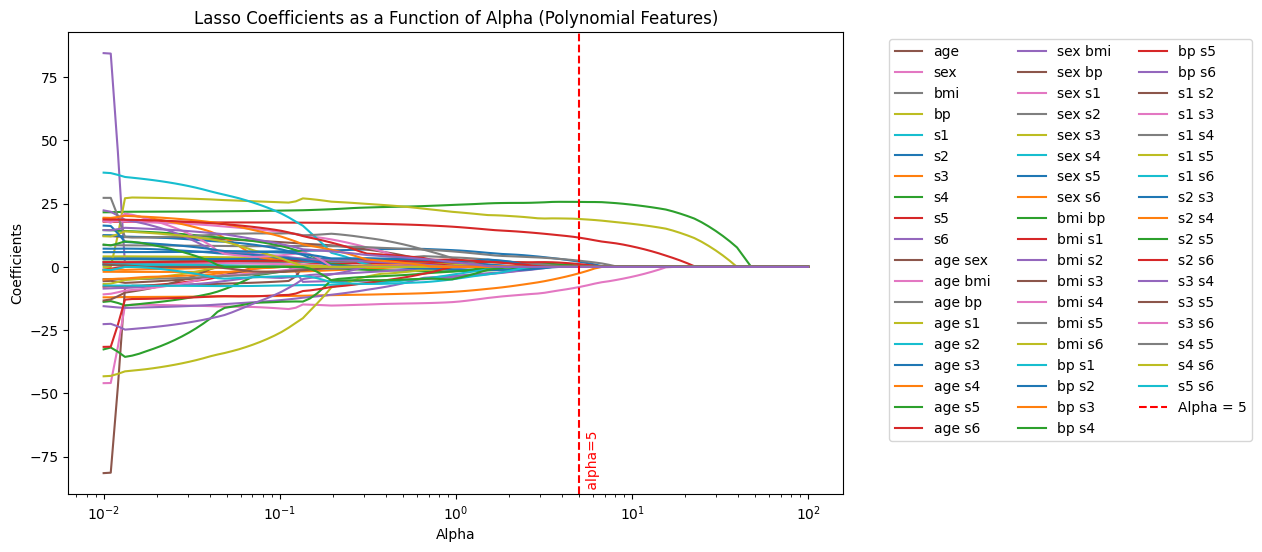

In [ ]:

from sklearn.linear_model import Lasso

lasso_poly_c = Lasso(alpha=5, max_iter=500000)
lasso_poly_c.fit(X_train_poly_s, y_train)

y_pred=lasso_poly_c.predict(X_test_poly_s)
r2_lasso_poly_c = r2_score(y_test, y_pred)

print(f"R² (Lasso + Polynomial): {r2_lasso_poly_c:.3f}")
print(f"Non-zero coefficients: {(lasso_poly_c.coef_ != 0).sum()} out of {len(lasso_poly_c.coef_)}")


#showing the coefficent path for lasso with fixed alpha on polynomial features
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
#Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
alphas = np.logspace(-2, 2, 100)
coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=500000)
    lasso.fit(X_train_poly_s, y_train)
    coefs.append(lasso.coef_)
coefs = np.array(coefs)
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as a Function of Alpha (Polynomial Features)')
# showing the features and alpha=5 line as legends
for i, feature in enumerate(feature_names):
    plt.plot([], [], label=feature) 
plt.axis('tight')
# showing a verical line at alpha=5 and writing alpha=5 next to it with angle=90 at the lower part of the line and showing legend
plt.axvline(x=5, color='red', linestyle='--', label='Alpha = 5')
plt.text(5.5, plt.ylim()[0], ' alpha=5', color='red', rotation=90, verticalalignment='bottom')
#placing legend outside the plot in two columns
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.show()

### Step 16: Identifying the Important Features

Again we want to create a plot to help us visualize which predictors remain active in the model and whether they have a positive or negative association with the target. Create a horizontal bar chart showing the non-zero Lasso coefficients for ``alpha = 5``. Follow the instructions in Step 8 for guidance.

**Hint**: the top 5 features should be identical to plot from Step 8.

Non-zero Lasso Coefficients (alpha = 5) for Polynomial Features sorted from largest to smallest:


Feature  Coefficient
2       bmi    25.690161
8        s5    18.941873
3        bp    11.581286
27   bmi bp     2.471126
10  age sex     2.074981
33   bmi s6     1.135663
12   age bp     0.500690
1       sex    -2.519322
6        s3    -7.954854

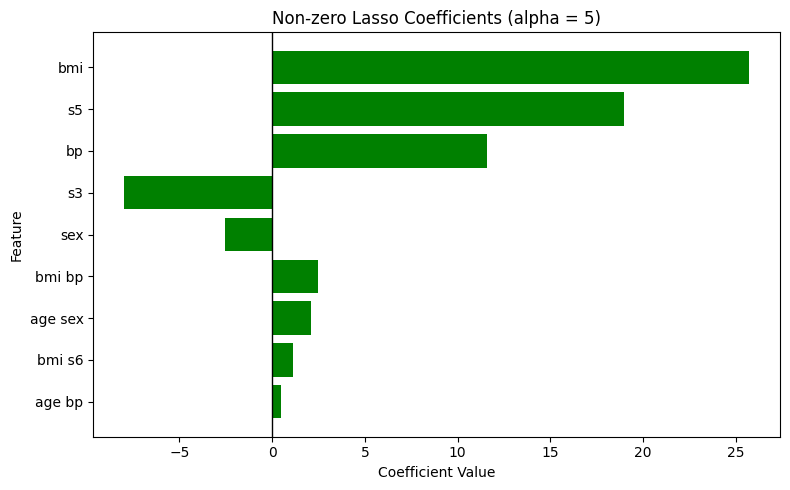

Lasso Intercept (alpha = 5) for Polynomial Features: 153.73654390934846


In [456]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature names and their coefficients
# Get feature names after polynomial expansion


feature_names = pf.get_feature_names_out()

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_poly_c.coef_
})

#display the non-zero coefficients DataFrame in a sorted manner from largest to smallest
print("Non-zero Lasso Coefficients (alpha = 5) for Polynomial Features sorted from largest to smallest:")
nonzero_coef_df = coef_df[coef_df['Coefficient'] != 0]
display(nonzero_coef_df.sort_values(by='Coefficient', ascending=False))

# Filter out zero coefficients
nonzero_df = coef_df[coef_df['Coefficient'] != 0]

# Sort by absolute value for clearer visualization
nonzero_df = nonzero_df.reindex(nonzero_df['Coefficient'].abs().sort_values(ascending=True).index)

# Plot
plt.figure(figsize=(8,5))
plt.barh(nonzero_df['Feature'], nonzero_df['Coefficient'], color='green')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Non-zero Lasso Coefficients (alpha = 5)')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

# showing intecept value
print(f"Lasso Intercept (alpha = 5) for Polynomial Features: {lasso_poly_c.intercept_}")

##### We have reduced the number of feathures by Lasso model. It is noted that the Lasso model is not used for its performance, but the feature reduction. Now, lets perform a **simple linear regression** model using the top 9 features.

In [532]:
# Performing linear regression using only the top 9 features identified by Lasso with alpha=5
from scipy import stats


top_features = nonzero_coef_df['Feature'].tolist()[:9]
X_train_top = X_train_poly_s[:, [list(feature_names).index(f) for f in top_features]]
X_test_top = X_test_poly_s[:, [list(feature_names).index(f) for f in top_features]]
lr_top = LinearRegression().fit(X_train_top, y_train)
r2_lr_top = r2_score(y_test, lr_top.predict(X_test_top))
print(f"R² (Linear Regression with Top 9 Lasso Features): {r2_lr_top:.3f}")

# printing feature names of the top 9 features used with their coefficients sorted from largest to smallest
print("==================================================")
print("Top 9 features used in Linear Regression with their coefficients:")
for feature, coef in sorted(zip(top_features, lr_top.coef_), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {coef:.3f}")

R² (Linear Regression with Top 9 Lasso Features): 0.535
Top 9 features used in Linear Regression with their coefficients:
bmi: 26.000
s5: 20.701
bp: 16.173
age sex: 6.811
bmi bp: 5.597
bmi s6: 3.945
age bp: 3.387
sex: -10.860
s3: -13.894


It can be observed that the model’s fit has improved compared to the initial linear regression performed on the original features, which achieved an $R^2 = 0.453$.  
After expanding the feature space using polynomial terms, applying **Lasso regularization** for feature selection, and then fitting a linear regression model on the reduced set, the performance increased to $R^2 = 0.535$.  
This indicates that introducing nonlinear interactions and removing irrelevant features helped the model capture more variance in the target variable while maintaining simplicity.

### 📈 Model Evaluation through Diagnostic Plots

After building a regression model, it is essential to evaluate its performance both **numerically** and **visually**.  
Visual diagnostics help reveal issues such as bias, nonlinearity, heteroscedasticity, and non-normal residuals that numeric metrics alone might miss.

Below are the most important plots and their mathematical foundations:

---

#### 1️⃣ Predicted vs. Actual Plot
This plot compares the **true values** (`y_test`) with the **predicted values** (`y_pred`).

$$
\text{Prediction: } \hat{y}_i = f(\mathbf{x}_i)
$$

A perfect model would satisfy:

$$
\hat{y}_i = y_i
$$

Points lying on the 45° diagonal line ($y = \hat{y}$) represent perfect predictions,  
while deviations from the line indicate underprediction or overprediction.

---

#### 2️⃣ Residual Plot
The **residual** for each observation is defined as:

$$
e_i = y_i - \hat{y}_i
$$

Residuals are plotted against fitted (predicted) values.  
A good regression model should show residuals **randomly scattered around zero**:

$$
\mathbb{E}[e_i] = 0, \quad \text{Var}(e_i) = \sigma^2
$$

Patterns or systematic structures in the plot (e.g., curvature or funnels) suggest that the model’s assumptions are violated —  
for example, missing nonlinear trends or heteroscedasticity (non-constant variance).

Here is an example of bad regression model:

Image taken from [here](https://online.stat.psu.edu/stat462/node/124/):

<img src="Bad_residual.png" alt="drawing" width="500"/>

This plot of residuals versus fits shows that the residual variance (vertical spread) increases as the fitted values (predicted values of sale price) increase. This violates the assumption of constant error variance [[Ref](https://online.stat.psu.edu/stat462/node/124/)].
In such case we need to refine our model or variables to improve the it.

---

#### 3️⃣ Histogram of Residuals
The histogram (often with a KDE curve) shows how the **residuals are distributed**.  
For a well-behaved regression model, residuals should approximately follow a **normal (Gaussian) distribution** centered at zero:
This means most errors are small and positive/negative errors are equally likely.  
A symmetric, bell-shaped histogram indicates that the model’s errors are **unbiased and consistent**.  
However:
- A **skewed** histogram suggests systematic overprediction or underprediction.  
- **Heavy tails** (leptokurtic shape) indicate the presence of outliers or high-variance regions.

---

#### 4️⃣ Q–Q Plot (Quantile–Quantile Plot)
To assess whether residuals follow a **normal distribution**, we standardize them:

$$
e_i^{*} = \frac{e_i - \bar{e}}{s_e}
$$

where $ \bar{e} $ is the mean of residuals and $ s_e $ is their standard deviation.

We then plot the **empirical quantiles** of $ e_i^{*} $ against the **theoretical quantiles** of a standard normal distribution:

$$
q_i = \Phi^{-1}\left(\frac{i - 0.5}{n}\right)
$$

where $ \Phi^{-1} $ is the inverse CDF (percent-point function) of the standard normal distribution.  
If the residuals are normally distributed, the points should align closely with the diagonal reference line.

---

#### ✅ Why These Plots Matter
- The **Predicted vs. Actual plot** checks overall accuracy and systematic bias.  
- The **Residual plot** verifies that errors are independent and randomly distributed.  
- The **Histogram of Residuals** confirms that residuals are approximately normal and unbiased.  
- The **Q–Q plot** provides a formal visual test for the normality assumption.

Together, these figures provide a comprehensive diagnostic check, confirming whether the model is **well-specified, unbiased, and generalizable**.

#### 👇 Now let's explore our model using the abovemnetioned figures.

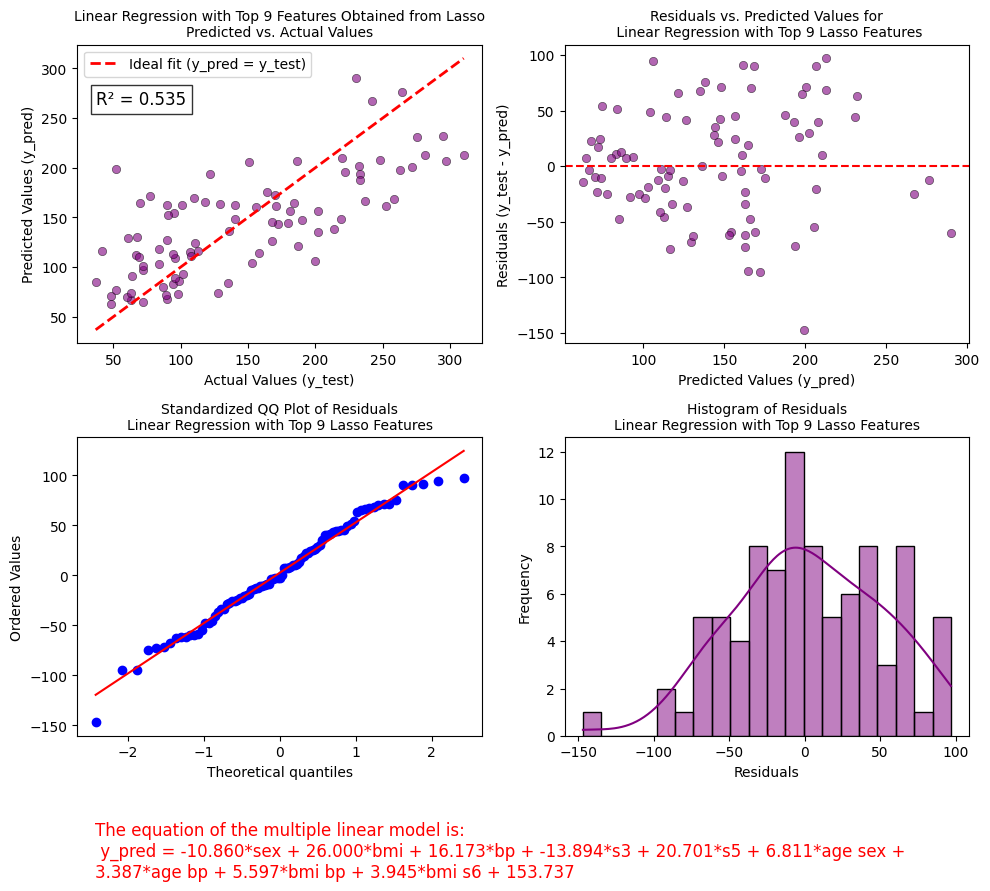

In [531]:
# Plot Predicted vs Actual and the residual plot for Linear Regression with Top 9 Lasso Features 
plt.figure(figsize=(10, 8))

# Predicted vs Actual
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_test, y=lr_top.predict(X_test_top), color='purple', alpha=0.6, edgecolor='k')

# Perfect fit line (y = x)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2, label='Ideal fit (y_pred = y_test)')
# Labels and title
plt.xlabel('Actual Values (y_test)', fontsize=10)
plt.ylabel('Predicted Values (y_pred)', fontsize=10)
plt.title('Linear Regression with Top 9 Features Obtained from Lasso\nPredicted vs. Actual Values', fontsize=10)
#  Move R² box slightly lower and right
plt.text(y_test.min() + (y_test.max() - y_test.min())*0.001,
         y_test.max()*0.85,
         f"R² = {r2_lr_top:.3f}",
         fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
#  Move legend to top-right to avoid overlap
plt.legend(loc='upper left')
plt.tight_layout()

# Residuals vs. Predicted
plt.subplot(2, 2, 2)
sns.scatterplot(x=lr_top.predict(X_test_top), y=(y_test - lr_top.predict(X_test_top)),color='purple', alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values (y_pred)')
plt.ylabel('Residuals (y_test - y_pred)')
plt.title('Residuals vs. Predicted Values for\n Linear Regression with Top 9 Lasso Features', fontsize=10)
plt.tight_layout()


# showing the equation of the linear regression model with top 9 features on the plot
equation_text_top = "y_pred = "
for feature, coef in zip(top_features, lr_top.coef_):
    equation_text_top += f"{coef:.3f}*{feature} + "
equation_text_top = equation_text_top[:-3]  # Remove last " + "
equation_text_top += f" + {lr_top.intercept_:.3f}"
plt.gcf().text(0.1, -0.1, "The equation of the multiple linear model is:\n " + equation_text_top, fontsize=12, wrap=True, color='Red')

# Plotting Standardized QQ plot and histogram of residuals for Linear Regression with Top 9 Lasso Features in a subplot
# Standardized QQ plot with purple color
plt.subplot(2, 2, 3)
stats.probplot(y_test - lr_top.predict(X_test_top), dist="norm", plot=plt)
plt.title('Standardized QQ Plot of Residuals\nLinear Regression with Top 9 Lasso Features', fontsize=10)
# Histogram of residuals
plt.subplot(2, 2, 4)
sns.histplot(y_test - lr_top.predict(X_test_top), bins=20, kde=True, color='purple')
plt.title('Histogram of Residuals\nLinear Regression with Top 9 Lasso Features', fontsize=10)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### 📊 Interpretation of Model Diagnostics

The diagnostic plots above illustrate how well the linear regression model (trained on the top 9 Lasso-selected features) performs on the Diabetes dataset:

- **Predicted vs. Actual Plot:**  
  The points generally follow the red dashed line, indicating a moderate positive correlation between the predicted and actual values. 

  In this example, the **R² value** shown on the plot quantifies how well the model explains the variance in the target variable:

  $ R^2$ = 1.0  → perfect prediction  
  $ R^2$ = 0.0  → no predictive power (random guess)

  The coefficient of determination ($R^2 = 0.535$) suggests that the model explains about 53% of the variance in the target variable.

- **Residuals vs. Predicted Plot:**  
  The residuals appear randomly scattered around zero, showing no strong pattern.  
  This indicates that the model captures most of the systematic variation, though the slightly wider spread at higher predicted values hints at mild heteroscedasticity.

- **Q–Q Plot of Residuals:**  
  Most points lie close to the diagonal reference line, implying that the residuals are approximately normally distributed.  
  Minor deviations at the tails suggest a few outliers but no severe violation of normality.

- **Histogram of Residuals:**  
  The residuals form a roughly symmetric, bell-shaped distribution centered near zero, supporting the assumption of unbiased errors.

Overall, the diagnostic plots confirm that the linear regression model fits the data reasonably well, with normally distributed and mostly independent residuals, though there remains room for improvement in explaining variance.


# Section 3. Conclusion

Given everything you have explored in this exercise (and what we discussed in the course) about **regularization, interaction terms, overfitting**, and **model generalizability**, what is your perspective on the **bias–variance trade-off** and the **interpretability trade-off** for this dataset?

Take a moment to reflect and collect your thoughts before revealing my answer below.

<details>
<summary>Click to reveal my answer</summary>

**Conclusion (my version)**

Across both experiments, **regularization consistently improves model performance**, confirming its role in **reducing variance** and **enhancing generalization**.

When we extend the feature space to include **interaction terms**, we observe a modest additional improvement in test-set R², indicating that these nonlinear interactions capture a small portion of residual structure that the purely linear model could not explain.

However, as seen from both the performance metrics and the most influential predictors identified by Lasso (α = 5), the qualitative story remains the same: the model’s insights and key drivers of diabetes progression are largely unchanged.

This suggests that, for this dataset, the relationships between predictors and the target are **predominantly linear and additive**, and the marginal gains from including polynomial interactions may not justify the added complexity or overfitting risk for future data.

In practice, this highlights an important modeling principle:

<u>**Regularization helps control variance, while model expansion helps reduce bias; but the goal is not maximum complexity, it’s meaningful simplicity**.<u>

After finaluzing our model, we can use the residual plots to obtain an overal obervation of our model performance.